# Shakespeare


```{contents}
:local:
```


In [61]:
from __future__ import annotations

import os
import time
import seaborn as sns

import matplotlib.pyplot as plt
from pathlib import Path
from typing import Any, Dict, List, Literal, Tuple, Union, Optional

import numpy as np
from numpy.typing import ArrayLike, NDArray
import requests
import tiktoken
import torch
from rich.pretty import pprint
from torch import nn
from torch.utils.data import DataLoader, Dataset
import os
import random
import warnings

import numpy as np
import torch
import torch.nn.functional as F
import torch.backends.cudnn

from pydantic import BaseModel, Field, model_validator, computed_field


## Composing the Configurations

In [62]:
class Composer(BaseModel):
    seed: int = 2024
    debug: bool = False

    url: str = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
    dataset_name: str = "tinyshakespeare"
    data_folder: str = Field(default="./data/tinyshakespeare", description="Path to the data folder")

    train_path: Path = Field(None, description="Path to the train file")
    valid_path: Path = Field(None, description="Path to the valid file")

    encoding_name: Literal['gpt2', 'r50k_base', 'p50k_base', 'p50k_edit', 'cl100k_base'] = "gpt2"

    batch_size: int = Field(default=64, description="Batch size")
    block_size: int = Field(default=128, description="Block size, an alias for max length/context window size.", alias="context_length")
    device_type: Literal["cpu", "cuda"] = "cpu"
    device: torch.device = Field(None, description="Device to use")

    # model parameters
    d_model: int = Field(default=512, description="Dimension of the model")
    d_ff: int = Field(default=512, description="Dimension of the feed forward layer")
    H: int = Field(default=8, description="Number of heads", alias="num_heads")
    vocab_size: int = Field(default=50257, description="Vocabulary size")
    num_decoder_blocks: int = Field(default=6, description="Number of decoder blocks")


    @model_validator(mode="after")
    def set_train_valid_paths(self) -> Composer:
        self.train_path = Path(self.data_folder) / "train.txt"
        self.valid_path = Path(self.data_folder) / "valid.txt"
        return self

    @model_validator(mode="after")
    def set_device(self) -> Composer:
        self.device = torch.device(self.device_type)
        return self

    @model_validator(mode="after")
    def set_debug_fields(self) -> Composer:
        if self.debug:
            self.batch_size = 2
            self.block_size = 8
            self.d_model = 4
            self.H = 2
            self.d_ff = 4
        return self

    class Config:
        extra = "allow"
        arbitrary_types_allowed = True

composer = Composer(debug=True)
pprint(composer)


Composer(
│   seed=2024,
│   debug=True,
│   url='https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt',
│   dataset_name='tinyshakespeare',
│   data_folder='./data/tinyshakespeare',
│   train_path=PosixPath('data/tinyshakespeare/train.txt'),
│   valid_path=PosixPath('data/tinyshakespeare/valid.txt'),
│   encoding_name='gpt2',
│   batch_size=2,
│   block_size=8,
│   device_type='cpu',
│   device=device(type='cpu'),
│   d_model=4,
│   d_ff=4,
│   H=2,
│   vocab_size=50257,
│   num_decoder_blocks=6
)

## Reproducibility

In [63]:
def configure_deterministic_mode() -> None:
    """
    See https://pytorch.org/docs/stable/generated/torch.use_deterministic_algorithms.html
    and https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility
    """
    # fmt: off
    torch.use_deterministic_algorithms(True, warn_only=True)
    torch.backends.cudnn.benchmark        = False
    torch.backends.cudnn.deterministic    = True
    torch.backends.cudnn.enabled          = False

    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    # fmt: on
    warnings.warn(
        "Deterministic mode is activated. This will negatively impact performance and may cause increase in CUDA memory footprint.",
        category=UserWarning,
        stacklevel=2,
    )


def seed_all(
    seed: int = 1992,
    seed_torch: bool = True,
    set_torch_deterministic: bool = True,
) -> int:
    """
    Seed all random number generators.

    Parameters
    ----------
    seed : int
        Seed number to be used, by default 1992.
    seed_torch : bool
        Whether to seed PyTorch or not, by default True.

    Returns
    -------
    seed: int
        The seed number.
    """
    # fmt: off
    os.environ["PYTHONHASHSEED"] = str(seed)       # set PYTHONHASHSEED env var at fixed value
    np.random.default_rng(seed)                    # numpy pseudo-random generator
    random.seed(seed)                              # python's built-in pseudo-random generator

    if seed_torch:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)           # pytorch (both CPU and CUDA)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.enabled = False

        if set_torch_deterministic:
            configure_deterministic_mode()
    # fmt: on
    return seed

In [64]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
attention_weights.shape

torch.Size([1, 1, 10, 10])

In [65]:
seed_all(composer.seed, seed_torch=True, set_torch_deterministic=False)

2024

## Tokenization and Vocabulary

- https://huggingface.co/learn/nlp-course/chapter2/4?fw=pt
- https://github.com/openai/tiktoken
- https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb

Language models don't see text like you and I, instead they see a sequence of numbers (known as tokens). Byte pair encoding (BPE) is a way of converting text into tokens. It has a couple desirable properties[^1]:

- It's reversible and lossless, so you can convert tokens back into the original text
- It works on arbitrary text, even text that is not in the tokeniser's training data
- It compresses the text: the token sequence is shorter than the bytes corresponding to the original text. On average, in practice, each token corresponds to about 4 bytes.
- It attempts to let the model see common subwords. For instance, "ing" is a common subword in English, so BPE encodings will often split "encoding" into tokens like "encod" and "ing" (instead of e.g. "enc" and "oding"). Because the model will then see the "ing" token again and again in different contexts, it helps models generalise and better understand grammar.

In [66]:
def am_i_in_jupyter() -> bool:
    try:
        from IPython import get_ipython
        if "IPKernelApp" not in get_ipython().config:
            return False
    except ImportError:
        return False
    return True

IN_JUPYTER = am_i_in_jupyter()

In [67]:
def download(url: str, dataset_name: str, dest_folder: Path | str) -> Path:
    dest_folder_path = Path(dest_folder)

    dest_folder_path.mkdir(parents=True, exist_ok=True)

    filepath = dest_folder_path / f"{dataset_name}.txt"

    response = requests.get(url, stream=True)
    corpus = response.text
    response.raise_for_status()

    with open(filepath, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    return filepath, corpus

In [68]:
filepath, corpus = download(composer.url, composer.dataset_name, composer.data_folder)
pprint(filepath)
print(corpus[:100])

PosixPath('data/tinyshakespeare/tinyshakespeare.txt')

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [69]:
N = len(corpus)
train_data = corpus[: int(N * 0.9)]
valid_data = corpus[int(N * 0.9) :]

# encode with tiktoken gpt2 bpe
tokenizer = tiktoken.get_encoding(composer.encoding_name)
tiktoken.list_encoding_names(), tokenizer.n_vocab

(['gpt2', 'r50k_base', 'p50k_base', 'p50k_edit', 'cl100k_base'], 50257)

In [70]:
train_ids = tokenizer.encode_ordinary(train_data)
valid_ids = tokenizer.encode_ordinary(valid_data)
print(f"train has {len(train_ids):,} tokens")
print(f"val has {len(valid_ids):,} tokens")

train has 301,966 tokens
val has 36,059 tokens


In [71]:
print(tokenizer.decode(train_ids[:2]))
print("-" * 80)
print(tokenizer.decode(train_ids[:100]))


First Citizen
--------------------------------------------------------------------------------
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we


In [72]:
# export to bin files
train_ids = np.array(train_ids, dtype=np.uint16)
valid_ids = np.array(valid_ids, dtype=np.uint16)

train_ids.tofile(composer.train_path)
valid_ids.tofile(composer.valid_path)

# train.bin has 301,966 tokens
# val.bin has 36,059 tokens

### STOI (TODO)

- The first `input` is the sentence `hello bot`.
- The tokenization is `[0, 3, 4, 1]` which correctly maps to the tokens `[<SOS>, hello, bot, <EOS>]` as per the `stoi` mapping.
- The shape is `[1, 4]` because we have one sentence with 4 tokens, where the first token is the `<SOS>` token and the last token is the `<EOS>` token.
    - In this context, the first dimension of the shape corresponds to the number of sentences (or samples) in the batch, and the second dimension corresponds to the number of tokens in each sentence.

---

In mathematical terms, we have:

- The vocabulary $\mathcal{V}$ consists of the unique tokens $\{\text{<SOS>, <EOS>, <PAD>, hello, bot, human}\}$ in our text data. The size of the vocabulary is $V = |\mathcal{V}| = 6$.

- We define a function $f_{\text{stoi}}$ that maps each token in our vocabulary to a unique integer index. 
  
  $$
  \begin{aligned}
  f_{\text{stoi}}: \mathcal{V} &\to \{0, 1, ..., V-1\} \\
  v &\mapsto f_{\text{stoi}}(v)
  \end{aligned}
  $$
  
  This function represents the `stoi` mapping in the code. For example, $f_{\text{stoi}}(\text{<SOS>}) = 0$, $f_{\text{stoi}}(\text{hello}) = 3$, etc.

- A sequence of text, such as the sentence "hello bot", is represented as a sequence of token indices $X=(x_1, x_2, x_3, x_4)$ using the $f_{\text{stoi}}$ mapping. For the sentence "hello bot", we have:
  
    $$
    \begin{aligned}
    \mathbf{X} &= (f_{\text{stoi}}(\text{<SOS>}), f_{\text{stoi}}(\text{hello}), f_{{\text{stoi}}}(\text{bot}), f_{\text{stoi}}(\text{<EOS>})) \\
    &= (0, 3, 4, 1)
    \end{aligned}
    $$

- Although $\mathbf{X}$ is a sequence, we can consider it to be a vector:

    $$
    \mathbf{X} = \begin{bmatrix} 0 & 3 & 4 & 1 \end{bmatrix} \in \mathbb{Z}^{1 \times 4}
    $$

    which correctly corresponds to the shape `[1, 4]` in the code.

## Dataset and Dataloading (Poor Man's Dataloader)

**TODO: to bridge the gap between the previous section and this one, we need to
explain why we need to construct a dataset.**

---

As Karpathy puts it, he implemented a poor man's
[dataloader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).
We will start by dissecting the code and understanding how it works and finally,
show that everything can be done with PyTorch's `Dataset` and `Dataloader`.

### Memory Mapping

Firstly, Karpathy uses `numpy`'s
[memory mapping](https://numpy.org/doc/stable/reference/generated/numpy.memmap.html)
(`numpy.memmap`) to load the data. Memory mapping is used to create a
memory-mapped array from a binary file. This involves mapping the contents of a
file directly into the virtual memory space of the calling process. This allows
applications to access the file data as if it were loaded in memory, using
pointer operations or array indexing, without the need for explicit read or
write operations.

This essentially means that you can access small segments of a large file
without having to load the entire file into memory. The concept draws
similarities to the use of [generators](https://wiki.python.org/moin/Generators)
in Python, where you can iterate over a large dataset without having to load the
entire dataset into memory.

In [73]:
train_data = np.memmap(composer.train_path, dtype=np.uint16, mode="r")
train_data_dtype = train_data.dtype
train_data_shape = train_data.shape

print(f"data_dtype: {train_data_dtype}, data_shape: {train_data_shape}")

data_dtype: uint16, data_shape: (301966,)


We see that the shape of train data is `(301966,)`, which means that it is a 1D (flattened) array 
with $301966$ elements - this is basically the length of the entire train corpus, in terms of
tokens.

### Notation, Context Length, Shuffling and Batching

However, we are not going to pass the entire training corpus as is to the model.
Instead, we are going to pass a **batch** of sequences (each sequence of length
`context_length`) to the model at a time.

#### Notation

Let's consider a sequence $\mathbf{x} = (x_1, x_2, \ldots, x_T)$, where:

-   $x_t$ represents the $t$-th token in the sequence,
-   Each token $x_t$ is an element of a predefined vocabulary $\mathcal{V} := \mathcal{X}$,
-   $T$ denotes the total number of tokens in the sequence, i.e., the sequence
    length.

In practice, we handle multiple sequences at once by grouping them into a batch.
This batch, denoted as $\mathcal{B}$, is then presented to the model for
parallel processing.

A batch of sequences is represented as a matrix $\mathbf{X}$, where each row
corresponds to a sequence in the batch. If the batch size is $\mathcal{B}$ and
each sequence within the batch has a fixed length $T$, then $\mathbf{X}$ can be
expressed as:

$$
    \mathbf{X} = \begin{bmatrix} x_{1,1} & x_{1,2} & \ldots & x_{1,T} \\ x_{2,1}
        & x_{2,2} & \ldots & x_{2,T} \\ \vdots & \vdots & \ddots & \vdots \\ x_{\mathcal{B},1} &
        x_{\mathcal{B},2} & \ldots & x_{\mathcal{B},T} \\\end{bmatrix} \in \mathbb{Z}^{\mathcal{B} \times T}
$$

Here, $x_{i,j}$ denotes the $j$-th token in the $i$-th sequence of the batch.
It's important to note that while we represent the sequences in a real-valued
space $\mathbb{Z}^{\mathcal{B} \times T}$ for mathematical convenience, in
practice, each $x_{i,j}$ corresponds to a discrete token from the vocabulary
$\mathcal{X}$ so using $\mathbb{Z}^{+}$ would be more appropriate.

#### Context Length / Block Size

$T$ is often referred to as the sequence length, or in the context of GPT, it is
the `block_size` or `context_length` or `max_seq_len`.

It is the length of the sequence that the model will be trained on and is also
the context length/context window that we often hear about.

For example,
[Gemini 1.5](https://blog.google/technology/ai/google-gemini-next-generation-model-february-2024)
was announced to have a standard $128,000$ token context window, up to a maximum
of $1$ million max length.

Typically, I think that if your model is trained on a certain context length, it
is not trivial to change it. For example, if you train a model on a context
length of $128$, you cannot simply change it to $256$ without retraining the
model. But it seems that it is increasingly possible to do so.

Let's look at an example, if we define our $L$ to be $32$, then we would expect each
sequence to be of length $32$.

In [74]:
first_sequence = train_data[0:0+32]
pprint(first_sequence)

first_sequence_decoded = tokenizer.decode(first_sequence)
print(first_sequence_decoded)

memmap([ 5962, 22307,    25,   198,  8421,   356,  5120,   597,  2252,
│   │      11,  3285,   502,  2740,    13,   198,   198,  3237,    25,
│   │     198,  5248,   461,    11,  2740,    13,   198,   198,  5962,
│   │   22307,    25,   198,  1639,   389], dtype=uint16)

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are


The example is just extracting $1$ such sequence $\mathbf{x}$ from the train
corpus. To leverage the prowess of linear algebra operations in CUDA, we would
typically pass a batch of sequences $\mathcal{B}$ to the model at a time.

Furthermore, we would require some level of randomness in the sequences that we
pass to the model to enable generalisation. You really do not want the model to
overfit to an ordered sequence of tokens in the training corpus.

To this end, let's see how Karpathy implements batching and shuffling of the
sequences.

#### Shuffling and Discrete Uniform Sampling

To enable shuffling, Karpathy generates a tensor of random integers (essentially a list of
random integers), which serve as indices. These indices are used to select
random sequences from the training (and validation) data.

For simplicity, let's look at the case where batch size is reduced to $\mathcal{B} = 1$.
This means we only need to sample $1$ sequence from the training data - and consequently
we only need $1$ random index.

We can easily achieve this via `torch.randint` which generates random integers
from a discrete uniform distribution over the half-open interval $[l, h)$,
and since we only want to sample $1$ sequence, we set `size=(1,)`.

In [75]:
generator = torch.Generator(device=composer.device)

generator.manual_seed(25)

low, high = 0, len(train_data) - composer.block_size
size = (1,)
indices: torch.Tensor = torch.randint(low=low, high=high, size=size, generator=generator)
pprint(indices)
pprint(indices.shape)

tensor([122484])

torch.Size([1])

The mathematical operation performed by `torch.randint(low, high, size, generator)` can be described as drawing samples from a uniform discrete distribution. Each element of the resulting tensor is an independent and identically distributed {cite}`radford2019language` (i.i.d.) random variable $X_i$ with the following probability mass function (PMF):

$$
\mathbb{P}(X_i = k) = \frac{1}{h - l} \quad \text{for} \, k = l, \ldots, h-1 
$$

This PMF implies that each integer in the range $[l, h-1]$ has an equal probability of being selected.

In our demonstration, we selected a random index, specifically $136,016$, from
our training dataset. This serves as a starting point for constructing a
sequence, denoted as $\mathbf{x}$. This sequence consists of the token found at
the chosen index and extends to include the subsequent $T$ tokens, where $T$
represents the block size. For the sake of simplicity, and to align with our
predefined settings, we have chosen $T = 8$. This block size is predetermined in
our `composer` configuration, activated specifically under a `debug` mode.

In code, we can achieve this by slicing the training data from the random index
to the random index plus the block size. This is done by `train_data[random_index:random_index+block_size]`.

In [76]:
random_sequence = train_data[indices:indices+composer.block_size]
pprint(random_sequence)
pprint(random_sequence.shape)

random_sequence_decoded = tokenizer.decode(random_sequence)
print(tokenizer.decode(random_sequence))

memmap([11503,   290, 21120,    30,   880,   788,    11, 29448],
│      dtype=uint16)

(8,)

 priest and clerk? well then, amen


One might wonder why the highest value of the random integers is
`len(self.train_data) - self.block_size`. This is mostly to prevent index out of
range errors. As we shall soon see, we are using these `indices` to slice a
sequence of length `block_size` from the data where you start slicing from the
index `index` and end at `index + block_size`.

#### Batching

Now that we understand how to sample a single sequence from the training data,
let's look at how we can sample a batch of sequences.
PyTorch made it easy for you, as we can just simply change the `size` parameter
to `(batch_size,)` so we can sample $\mathcal{B}$ number of indices - and
consequently $\mathcal{B}$ number of sequences.

In our case, if we set $\mathcal{B} = 2$, we would expect to get $2$ random
indices.

In [77]:
generator = torch.Generator(device=composer.device)
generator.manual_seed(25)
low, high = 0, len(train_data) - composer.block_size
size = (composer.batch_size,)
indices: torch.Tensor = torch.randint(low=low, high=high, size=size, generator=generator)
pprint(indices)
pprint(indices.shape)

tensor([122484, 196406])

torch.Size([2])

We then construct a batch of 
input sequences $\mathcal{B}$ by selecting the tokens at the
indices $122,484$ and $196,406$ and the next $T$ tokens via a for loop - and using `torch.stack`
to stack the sequences into a tensor of shape $\mathbb{Z}^{\mathcal{B} \times L}$.

So the first row of the batch would be the sequence starting at index $122,484$
and the second row would be the sequence starting at index $196,406$, with each
sequence having a length of $T=8$.

In [78]:
x = torch.stack([torch.from_numpy((train_data[index : index + composer.block_size]).astype(np.int64)) for index in indices])
pprint(x)
pprint(x.shape)

tensor([[11503,   290, 21120,    30,   880,   788,    11, 29448],
│   │   [  326,  8616,   373, 14855,    13,   198,   198, 37286]])

torch.Size([2, 8])

It is worth reconciling the fact that the slicing uses `[index:index + block_size]` and
therefore completes the reasoning behind the `len(self.train_data) - self.block_size` in
the `torch.randint` function call - to prevent index out of range errors. Consider
that if we do not subtract `block_size` from the length of the training data, we might
end up with an index that is the last index of the training data, and when we add
`block_size` to it, we would end up with an index that is out of range.

### Construction of Input and Target Sequences

As we will define more formally later, GPT model is an autoregressive
self-supervised learning model{cite}`math11112451` that directly learns a
conditional probability distribution $\mathbb{P}(x_t | x_{<t} ; \Theta)$ over
the vocabulary $\mathcal{V}$ of tokens, which is conditioned on the entire
history of tokens $x_{<t} = (x_1, x_2, \ldots, x_{t-1})$.

We have seen earlier how to construct an input sequence $\mathbf{x}$ from the
training data. To put things into perspective, we consider again the first
sequence that we constructed from the training data:

$$
\mathbf{x} = \begin{bmatrix} 11503 & 290 & 21120 & 30 & 880 & 788 & 11 & 29448 \end{bmatrix}
$$

representing the sentence `'priest and clerk? well then, amen'`.

Given the autoregressive and self-supervised nature, in order to construct the
target sequence $\mathbf{y}$, we simply shift the input sequence by one token to
the left. This means that the target sequence $\mathbf{y}$ is:

$$
\mathbf{y} = \begin{bmatrix} 290 & 21120 & 30 & 880 & 788 & 11 & 29448 & 13 \end{bmatrix}
$$

representing the sentence `'and clerk? well then, amen.'`. Note here $13$
is the index of the next token after the last token in the input sequence.

This behaviour is autoregressive because we are using the context tokens
$x_{<t}$ to predict the next token $x_t$, and self-supervised because we are
using the input sequence $\mathbf{x}$ to construct the target sequence
$\mathbf{y}$ without any external labels.

To illustrate further, the prediction process during training is cumulative:

-   For predicting $x_2$, the model uses $x_1$ as context:
    $\mathbb{P}\left(x_2 \mid x_1\right)$.
-   For predicting $x_3$, the model uses both $x_1$ and $x_2$ as context:
    $\mathbb{P}\left(x_3 \mid x_1, x_2\right)$.
-   This pattern continues, such that for predicting $x_t$, the model uses
    $x_1, x_2, \ldots, x_{t-1}$ as context:
    $\mathbb{P}\left(x_t \mid x_1, x_2, \ldots, x_{t-1}\right)$

In code, we can achieve this by simply slicing the adding a `1` to the `index`
in the `train_data` slicing operation.

In [79]:
y = torch.stack([torch.from_numpy((train_data[index + 1: index + 1 + composer.block_size]).astype(np.int64)) for index in indices])
pprint(y)
pprint(y.shape)

tokenizer.decode(y[0].numpy())

tensor([[  290, 21120,    30,   880,   788,    11, 29448,    13],
│   │   [ 8616,   373, 14855,    13,   198,   198, 37286,   406]])

torch.Size([2, 8])

' and clerk? well then, amen.'

### Asynchronous Data Loading and Prefetching

As we approach the last part of the code, Karpathy moves `x` and `y` to the
device and returns them.

In [80]:
if composer.device_type == "cuda":
    # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
    x, y = x.pin_memory().to(composer.device, non_blocking=True), y.pin_memory().to(composer.device, non_blocking=True)
else:
    x, y = x.to(composer.device), y.to(composer.device)

This is a common operation in PyTorch, where we move the data to the underlying
device (CPU or GPU or MPS) to leverage the processing capabilities of the
device. It goes without saying that modern deep learning models are trained on
GPUs - and CUDA is the de facto standard for GPU-accelerated computing.

CUDA allows a `pin_memory` and `non_blocking` parameter to be set when transferring
tensor data from CPU to GPU. The `pin_memory` parameter is used to allow `.to("cuda")`
to be more [performant](https://devblogs.nvidia.com/how-optimize-data-transfers-cuda-cc/)
as it avoids some implicit CPU-to-CPU copies. Tensors which are pinned in memory
also allow the transfer from CPU to GPU to be done asynchronously via `non_blocking` with respect to
the host[^2].

It can be useful because we can do some other work in CPU while the data is being
transferred to GPU. Consider the below scenario:

- `tensor.pin_memory().to("cuda", non_blocking=True)` will transfer the tensor
  to the GPU asynchronously, and the CPU can continue doing some other work.
- While waiting, CPU can do some other operations without waiting for the
  transfer to complete,
- Once `tensor` is transferred to the GPU, then we can do some other operations
  on the GPU.

What is worth noting is that CUDA manages the synchronization such that
operations on the GPU will not start until the transfer is complete. However, CUDA
programming is complex and is out of the scope of this post. Interested readers
can see the reference section.

### Collating Everything Together

In [81]:
def get_batch(
    composer: Composer,
    *,
    split: Literal["train", "valid"],
    batch_size: int,
    block_size: int,
    generator: torch.Generator,
    device: torch.device,
    device_type: Literal["cpu", "cuda"] = "cpu",
) -> Tuple[torch.Tensor, torch.Tensor]:
    # We recreate np.memmap every batch to avoid a memory leak, as per
    # https://stackoverflow.com/questions/45132940/numpy-memmap-memory-usage-want-to-iterate-once/61472122#61472122
    if split == "train":
        data = np.memmap(composer.train_path, dtype=np.uint16, mode="r")
    else:
        data = np.memmap(composer.valid_path, dtype=np.uint16, mode="r")

    low, high = 0, len(data) - block_size
    size = (batch_size,)

    indices = torch.randint(low=low, high=high, size=size, generator=generator)

    x = torch.stack([torch.from_numpy((data[index : index + block_size]).astype(np.int64)) for index in indices])
    y = torch.stack(
        [torch.from_numpy((data[index + 1 : index + 1 + block_size]).astype(np.int64)) for index in indices]
    )
    if device_type == "cuda":
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y

In [82]:
generator = torch.Generator(device=composer.device)
generator.manual_seed(25)
train_batch = get_batch(composer, split="train", batch_size=composer.batch_size, block_size=composer.block_size, device=composer.device, generator=generator)
x, y = train_batch
pprint(x)
pprint(y)

tensor([[11503,   290, 21120,    30,   880,   788,    11, 29448],
│   │   [  326,  8616,   373, 14855,    13,   198,   198, 37286]])

tensor([[  290, 21120,    30,   880,   788,    11, 29448,    13],
│   │   [ 8616,   373, 14855,    13,   198,   198, 37286,   406]])

### Using PyTorch's Dataset and Dataloader

It is relatively simple to understand - and since there is not a need to
[collate](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn) the
data, which makes things a bit easier.

## Generative Pre-trained Transformer (GPT)

```{figure} ./assets/sebastian-decoder.jpeg
---
name: sebastian-decoder
---
GPT Architecture. Image Credit: Build a Large Language Model (From Scratch) by Sebastian Raschka
```

## Token Embeddings

First, we will look at the first sequence, given by `' priest and clerk? well then, amen'`,
which we have already mapped to its corresponding token IDs.

$$
\mathbf{x} = \begin{bmatrix} 11503 & 290 & 21120 & 30 & 880 & 788 & 11 & 29448 \end{bmatrix}
$$

The shape is $1 \times 8$, which is a single sequence of $8$ tokens. And in this case, 
we have each word/punctuation mapped to a unique token ID, as seen below.

In [83]:
for token in x[0]:
    print(f"Token ID: {token.item()}, Token: {tokenizer.decode([token.item()])}")

Token ID: 11503, Token:  priest
Token ID: 290, Token:  and
Token ID: 21120, Token:  clerk
Token ID: 30, Token: ?
Token ID: 880, Token:  well
Token ID: 788, Token:  then
Token ID: 11, Token: ,
Token ID: 29448, Token:  amen


Next, we need to map each token to a vector (embeddings) in a high-dimensional
space.

The integer tokens, by themselves, do not carry much information. For example,
the word `priest` is tokenized to be `11503`, which is an arbitrary integer. In
a one-dimensional Euclidean space, the word `priest` and the next word `and`,
indexed by `290`, **_would appear to be very far apart from each other_**.
However, if we were to change a tokenizer, and somehow the word `priest` is now
tokenized to be `291`, then the words `priest` and `and` **_would appear to be
very near to each other_**.

This means that the model could potentially learn the relationship of two tokens
based solely on their tokenized integers. To address this, we use embedding
vectors. While the initial mapping from words to vectors is dependent on the
tokenizer and may be arbitrary, during training, the model adjusts these vectors
so that words used in similar contexts come to have similar vectors. This allows
the model to capture semantic relationships between words - and by extension,
allows the model to capture relationships between tokens better.

In [84]:
x0 = x[0]
pprint(tokenizer.decode(x0.cpu().numpy()))
pprint(x0)

' priest and clerk? well then, amen'

tensor([11503,   290, 21120,    30,   880,   788,    11, 29448])

In [85]:
torch.manual_seed(composer.seed)

tok_embed = nn.Embedding(num_embeddings=composer.vocab_size, embedding_dim=composer.d_model)
x0_tok_embed = tok_embed(x0)
pprint(x0_tok_embed)
pprint(x0_tok_embed.shape)

tensor([[-1.0213,  0.3146, -0.2616,  0.3730],
│   │   [ 0.5715,  0.1229, -0.8145, -1.4164],
│   │   [ 0.4973, -1.1740, -0.6713, -0.1102],
│   │   [-2.3167,  0.2943,  0.9573,  0.2935],
│   │   [ 0.0623, -0.1054,  0.8182, -2.4184],
│   │   [-1.4016,  0.3422, -0.9704, -0.2435],
│   │   [-0.0576, -0.0596,  0.2764, -0.2403],
│   │   [ 1.2707, -0.5865, -1.4099, -1.3797]], grad_fn=<EmbeddingBackward0>)

torch.Size([8, 4])

### Lookup Operation

So this operation above is essentially a lookup operation, where we look up the
embedding vector for each token in the sequence. This is done by
`self.token_embeddings(x)`. We run it against the first sequence for simplicity,
and `x0_tok_embed` is the resulting tensor, with a shape of $T \times D$. In our
case, the sequence length (block size) is $T = 8$, and the embedding dimension
is $D = 4$. This means that we have essentially mapped each of the $8$ tokens
representing `priest and clerk? well then, amen` to a $4$-dimensional vector.

-   `priest` is mapped to `[-1.0213, 0.3146, -0.2616, 0.3730]`
-   `and` is mapped to `[ 0.5715, 0.1229, -0.8145, -1.4164]`
-   ...
-   `amen` is mapped to `[ 1.2707, -0.5865, -1.4099, -1.3797]`

With each token being a vector, not only does the token carry more information,
it is also much easier to do linear algebra operations on the tokens. For
example, we can easily calculate the mean/sum of the embeddings for pooling, or
we can easily calculate the dot product between two tokens to measure their
similarity in a high-dimensional space (as compared to it being an integer with
only 1 dimension).

Furthermore, the embeddings are learned during training, and the model would try
to capture semantic relationships between tokens. For example, the model would
try to learn that `priest` and `clerk` are related in some way because they
refer to people, and `amen` is related to `priest` because it is often used in
religious contexts.

### Token Embedding Matrix

$\mathbf{W}^{e}$: is the embedding matrix defined as:

$$
\mathbf{W}^{e} = \begin{bmatrix} e_{1,1} & e_{1,2} & \cdots & e_{1,D} \\ e_{2,1} & e_{2,2} & \cdots & e_{2,D} \\ \vdots & \vdots & \ddots & \vdots \\ e_{V,1} & e_{V,2} & \cdots & e_{V,D} \end{bmatrix} \in \mathbb{R}^{V \times D}
$$

where

-   $V := \lvert \mathcal{V} \rvert$: is the vocabulary size.
-   $D$: is the embedding dimension.
-   $e_{j, d}$: is the embedding element at position $j, d$. For a word $v_j$ in
    the vocabulary $\mathcal{V}$, the corresponding row in $\mathbf{W}^{e}$ is
    the embedding vector for that word.

### Representation Mapping

Define a function $h_{\text{tok_embed}}: \mathcal{V} \to \mathbb{R}^{D}$ such
that for each token $x_t \in \mathcal{V}$, the function
$h_{\text{tok_embed}}(x_t) = \mathbf{W}^{e}_{\text{index}(x_t)}$ returns the
embedding vector from $\mathbf{W}^{e}$, where $\text{index}(x_t)$ is the index
of $x_t$ in the vocabulary $\mathcal{V}$ (often times $x_t$ is already an
integer index).

### One-Hot Encoding and Embedding Matrix

It is worth noting that the underlying mechanism of calling `tok_embed(x)` is
the same as performing a matrix multiplication between a one-hot encoded vector
and the embedding matrix. This is because the one-hot encoded vector is a sparse
vector with only one non-zero element, and when multiplied with the embedding
matrix, it selects the row corresponding to the non-zero element.

In [86]:
x0_ohe = F.one_hot(x0, num_classes=composer.vocab_size)
x0_ohe = x0_ohe.float()
assert x0_ohe.shape == (composer.block_size, composer.vocab_size) # [8, 50257]

for index, token_id in enumerate(x0):
    assert x0_ohe[index, token_id].item() == 1.0 # check if the one-hot encoding is correct

-   Recall our tokenized sequence is
    `[11503, 290, 21120, 30, 880, 788, 11, 29448]`.
-   Converting it to one-hot encoding, we would have a matrix of size
    `[8, 50257]` (or more generally `[B, T, V]` in the presence of batch size
    `B`).
-   Each row is a one-hot vector of the token $x_{t} \in \mathbb{R}^{V}$ at
    position $t$. For example, the first row would be a one-hot vector of the
    token `11503`, so every element in the first row is $0$ except for the
    $11503$-th element, which is $1$.
-   A minute quirk here is that the token $x_{t}$ exists in the **_continuous
    space_** instead of the **_discrete space_**. This is because we have to
    perform the dot product between the one-hot vector and the embedding vector,
    which is a continuous vector. This is more of a data type coercion.
    Therefore, in our code, we also converted the one-hot vector to `.float()`.


In [87]:
embedding_matrix = tok_embed.weight.data
x0_ohe_tok_embed = x0_ohe @ embedding_matrix
torch.testing.assert_close(x0_tok_embed, x0_ohe_tok_embed, rtol=0.0, atol=0.0)

Indeed, we see that the result of `tok_embed(x)` is the same as the result of
`x0_ohe @ embedding_matrix`. In other words, you can one hot encoded the input
sequence $\mathbf{x} = (x_1, x_2, \ldots, x_T)$ and then matrix multiply it with the
embedding matrix $\mathbf{W}^{e}$ (via a linear layer) to get the same result as `tok_embed(x)`.

-   $\mathbf{O}$: one-hot representation of the input sequence
    $\mathbf{x} = (x_1, x_2, \ldots, x_T)$. This is a $T \times V$ matrix, where
    each row represents a token in the sequence and each column corresponds to a
    unique word in the vocabulary $\mathcal{V}$.

    $$
    \begin{aligned}
    \mathbf{O} &= \begin{bmatrix} o_{1,1} & o_{1,2} & \cdots & o_{1,V} \\ o_{2,1} & o_{2,2} & \cdots & o_{2,V} \\ \vdots & \vdots & \ddots & \vdots \\ o_{T,1} & o_{T,2} & \cdots & o_{T,V} \end{bmatrix} \in \mathbb{R}^{T \times V} \\
    &= \begin{bmatrix} \text{---} & \mathbf{o}_{1, :} & \text{---} \\ \text{---} & \mathbf{o}_{2, :} & \text{---} \\ & \vdots & \\ \text{---} & \mathbf{o}_{T, :} & \text{---} \end{bmatrix} \in \mathbb{R}^{T \times V}
    \end{aligned}
    $$

    where

    -   $T$: is the sequence length.
    -   $V$: is the vocabulary size.
    -   $o_{t, j}$: is the one-hot encoded element at position $t, j$. For a
        given token $x_t$ at the $t$-th position in the sequence $\mathbf{x}$,
        if $f_{\text{stoi}}(x_t)=j$, then the element at position $j$ in the
        one-hot vector for token $x_i$ is 1, and all other elements are 0.
    -   $\mathbf{o}_{t, :}$: is the one-hot encoded vector for the token $x_t$
        at the $t$-th position in the sequence $\mathbf{x}$. This row form is
        more important than column form because it serves as the lookup key for
        the embedding matrix $\mathbf{W}^{e}$.

-   $\mathbf{Z}$: is the output tensor of the embedding layer, obtained by
    matrix multiplying $\mathbf{O}$ with $\mathbf{W}^{e}$, and it is defined as:

    $$
    \mathbf{Z} = \mathbf{O} \cdot \mathbf{W}^{e}
    $$

    $$
    \begin{aligned}
    \mathbf{Z} &= \mathbf{O} \cdot \mathbf{W}^{e} \\
    &= \begin{bmatrix} z_{1,1} & z_{1,2} & \cdots & z_{1,D} \\ z_{2,1} & z_{2,2} & \cdots & z_{2,D} \\ \vdots & \vdots & \ddots & \vdots \\ z_{T,1} & z_{T,2} & \cdots & z_{T,D} \end{bmatrix} \in \mathbb{R}^{T \times D} \\
    &= \begin{bmatrix} \text{---} & \mathbf{z}_{1,:} & \text{---} \\ \text{---} & \mathbf{z}_{2,:} & \text{---} \\ & \vdots & \\ \text{---} & \mathbf{z}_{T,:} & \text{---} \end{bmatrix} \in \mathbb{R}^{T \times D}
    \end{aligned}
    $$

    where

    -   $T$: is the sequence length.
    -   $D$: is the embedding dimension.
    -   $z_{t, d}$: is the element at position $t, d$ in the tensor
        $\mathbf{Z}$. For a token $x_t$ at the $t$-th position in the sequence,
        $z_{t, :}$ is the $D$ dimensional embedding vector for that token.
    -   $\mathbf{z}_{t, :}$: is the $D$ dimensional embedding vector for the
        token $x_t$ at the $t$-th position in the sequence.

        In this context, each token in the sequence is represented by a $D$
        dimensional vector. So, the output tensor $\mathbf{Z}$ captures the
        dense representation of the sequence. Each token in the sequence is
        replaced by its corresponding embedding vector from the embedding matrix
        $\mathbf{W}^{e}$.

        As before, the output tensor $\mathbf{Z}$ carries semantic information
        about the tokens in the sequence. The closer two vectors are in this
        embedding space, the more semantically similar they are.

### Implementation

In [88]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, d_model: int) -> None:
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=d_model)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.embedding(x)

In [89]:
generator = torch.Generator(device=composer.device)
generator.manual_seed(25)

tok_embed = TokenEmbedding(vocab_size=composer.vocab_size, d_model=composer.d_model)
W_e = tok_embed.embedding.weight.data

In [90]:
x0 = x0.unsqueeze(dim=0) if x0.ndim == 1 else x0 # [T] -> [B, T]

z0_tok_embed = tok_embed(x0)
assert z0_tok_embed.shape == (1, composer.block_size, composer.d_model) # [B, T, D] = [1, 8, 4]

z0_ohe = F.one_hot(x0, num_classes=composer.vocab_size).float()
assert z0_ohe.shape == (1, composer.block_size, composer.vocab_size) # [T, V] = [8, 50257]

z0_tok_embed_matmul = F.one_hot(x0, num_classes=composer.vocab_size).float() @ W_e
torch.testing.assert_close(z0_tok_embed, z0_tok_embed_matmul, rtol=0.0, atol=0.0, msg="The matrix multiplication is not correct.")

## Positional Embeddings

For the lack of a better phrase, we say that self-attention, the core function
of GPTs, is permutation invariant. While it is obvious that the input sequence
$\mathbf{x}$ is ordered in the sense that $x_1$ comes before $x_2$, and $x_2$
comes before $x_3$, and so on, this information gets lost in the self-attention
mechanism. This means that the model does not differentiate "the cat ate the
mouse" from "the mouse ate the cat" as long as the tokens are the same - and
this is not desirable.

The dominant approach for preserving information about the order of tokens is to
represent this to the model as an additional input associated with each token.
These inputs are called positional encodings, and they can either be learned or
fixed _a priori_ {cite}`zhang2023dive`. What this means is that we can either
construct a learnable parameter that is updated during training, or we can
construct a fixed parameter that is not updated during training. For the sake of
completeness, we will discuss briefly the scheme where the positional encodings
are fixed _a priori_ based on sinusoidal functions - which is also the scheme
described in the paper "Attention is All You Need" {cite}`vaswani2017attention`.

### Definition

```{prf:definition} Positional Encoding
:label: decoder-positional-encoding

The positional encoding function
$\mathrm{PE}: \mathbb{N} \times \mathbb{N} \rightarrow \mathbb{R}$ computes the
position encoding for each position $p := t \in \mathbb{N}$ and each dimension
$d = 1, 2, \ldots, D \in \mathbb{N}$ in the input embedding space as follows {cite}`math11112451`:

$$
\operatorname{PE}(p, d)= \begin{cases}\sin \left(\frac{p}{10000^{\frac{2 d}{D}}}\right) & \text { if } d \text { is even, } \\ \cos \left(\frac{p}{10000^{\frac{2 d-1}{D}}}\right) & \text { if } d \text { is odd. }\end{cases}
$$
```

Note that $10,000$ is an parameter that can be tuned.

Thus, the entire tensor $\mathbf{P}$ is defined as:

$$
\mathbf{P} = \begin{bmatrix} p_{1,1} & p_{1,2} & \cdots & p_{1,D} \\ p_{2,1} & p_{2,2} & \cdots & p_{2,D} \\ \vdots & \vdots & \ddots & \vdots \\ p_{L,1} & p_{L,2} & \cdots & p_{L,D} \end{bmatrix} \in \mathbb{R}^{L \times D}
$$

where

-   $L$: is the sequence length.
-   $D$: is the embedding dimension.
-   $p_{i, d}$: is the element at position $i, d$ in the tensor
    $\mathbf{P}$.

Note that $\mathbf{P}$ is independent of $\mathbf{Z}$, and it's computed
based on the positional encoding formula used in transformers, which uses
sinusoidal functions of different frequencies.

### More Intuition on Positional Encodings (Pretty bad analogy, to revise)

Consider a sentence "Mary visited the museum in Paris."

The original word embeddings ($\mathbf{Z}$) can be thought of as guests at a
party, where each guest represents a word: 'Mary,' 'visited,' 'the,' 'museum,'
'in,' and 'Paris.' The personality of each guest represents the semantic meaning
of the word they represent.

Now, let's think of the positional encoding ($\mathbf{P}$) as the order in which
these guests arrived at the party. This captures the positional information in
the sentence. 'Mary' was the first to arrive, 'visited' the second, and so on.

When we add the positional encoding to the original embeddings
($\mathbf{Z} = \mathbf{Z} + \mathbf{P}$), we're basically combining the
personality of each guest (the meaning of the word) with their arrival order at
the party (their position in the sentence).

So, for example, 'Mary' isn't just represented as a proper noun referring to a
person, but she's also identified as the first person who arrived at the party.
Similarly, 'Paris' isn't just a proper noun referring to a city, but it's the
last entity that arrived.

This way, the combined tensor ($\mathbf{Z} = \mathbf{Z} + \mathbf{P}$) captures
both the semantic meaning and the positional information for each word, allowing
the Transformer to understand both the meaning of the words and their order in
the sentence. This is crucial because, in many languages, changing the order of
words can drastically alter the meaning of a sentence.

### An Example of Positional Encoding

To demonstrate how positional encodings are calculated for an input sequence
using the given formula, let's take the first three tokens from the example
sequence `' priest and clerk? well then, amen'`. We'll assume these tokens are
'priest', 'and', 'clerk' and that we're dealing with an embedding dimension
$D = 4$ for simplicity. The positions $p$ of these tokens are 1, 2, and 3,
respectively.

For $D = 4$, each token's positional encoding will be a vector of 4 elements.
Let's calculate the positional encodings for $p = 1, 2, 3$ (corresponding to
'priest', 'and', 'clerk?') and for each dimension $d = 0, 1, 2, 3$:

#### Positional Encoding for $p = 1$ ('priest')

-   $d = 0$ (even): $\sin\left(\frac{1}{10000^{0/4}}\right) = \sin(1)$
-   $d = 1$ (odd):
    $\cos\left(\frac{1}{10000^{1/4}}\right) =
    \cos\left(\frac{1}{\sqrt[4]{10000}}\right)$
-   $d = 2$ (even):
    $\sin\left(\frac{1}{10000^{2/4}}\right) =
    \sin\left(\frac{1}{\sqrt{10000}}\right)$
-   $d = 3$ (odd):
    $\cos\left(\frac{1}{10000^{3/4}}\right) =
    \cos\left(\frac{1}{\sqrt[4]{10000^3}}\right)$

#### Positional Encoding for $p = 2$ ('and')

-   $d = 0$ (even): $\sin\left(\frac{2}{10000^{0/4}}\right) = \sin(2)$
-   $d = 1$ (odd):
    $\cos\left(\frac{2}{10000^{1/4}}\right) =
    \cos\left(\frac{2}{\sqrt[4]{10000}}\right)$
-   $d = 2$ (even):
    $\sin\left(\frac{2}{10000^{2/4}}\right) =
    \sin\left(\frac{2}{\sqrt{10000}}\right)$
-   $d = 3$ (odd):
    $\cos\left(\frac{2}{10000^{3/4}}\right) =
    \cos\left(\frac{2}{\sqrt[4]{10000^3}}\right)$

#### Positional Encoding for $p = 3$ ('clerk?')

-   $d = 0$ (even): $\sin\left(\frac{3}{10000^{0/4}}\right) = \sin(3)$
-   $d = 1$ (odd):
    $\cos\left(\frac{3}{10000^{1/4}}\right) =
    \cos\left(\frac{3}{\sqrt[4]{10000}}\right)$
-   $d = 2$ (even):
    $\sin\left(\frac{3}{10000^{2/4}}\right) =
    \sin\left(\frac{3}{\sqrt{10000}}\right)$
-   $d = 3$ (odd):
    $\cos\left(\frac{3}{10000^{3/4}}\right) =
    \cos\left(\frac{3}{\sqrt[4]{10000^3}}\right)$

The use of $10000^{(\cdot/D)}$ with large exponents is designed to provide a
wide range of frequencies, enabling the model to distinguish between positions
at different scales. In practice, the positional encodings for high-dimensional
embeddings (e.g., $D=512$ in real models) involve very small and precise values,
facilitating the model's learning of complex positional relationships.



### Implementation

In [91]:
from abc import ABC, abstractmethod

import torch
from torch import nn


class PositionalEncoding(ABC, nn.Module):
    def __init__(self, d_model: int, context_length: int, dropout: float = 0.0) -> None:
        super().__init__()
        self.d_model = d_model
        self.context_length = context_length
        self.dropout = nn.Dropout(p=dropout, inplace=False)

    @abstractmethod
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        ...


class Sinusoid(PositionalEncoding):
    P: torch.Tensor

    def __init__(self, d_model: int, context_length: int, dropout: float = 0.0) -> None:
        super().__init__(d_model, context_length, dropout)

        P = self._init_positional_encoding()
        self.register_buffer("P", P, persistent=True)  # with this no need requires_grad=False

    def _init_positional_encoding(self) -> torch.Tensor:
        """Initialize the positional encoding tensor."""
        P = torch.zeros((1, self.context_length, self.d_model))
        position = self._get_position_vector()
        div_term = self._get_div_term_vector()
        P[:, :, 0::2] = torch.sin(position / div_term)
        P[:, :, 1::2] = torch.cos(position / div_term)
        return P

    def _get_position_vector(self) -> torch.Tensor:
        """Return a vector representing the position of each token in a sequence."""
        return torch.arange(self.context_length, dtype=torch.float32).reshape(-1, 1)

    def _get_div_term_vector(self) -> torch.Tensor:
        """Return a vector representing the divisor term for positional encoding."""
        return torch.pow(
            10000,
            torch.arange(0, self.d_model, 2, dtype=torch.float32) / self.d_model,
        )

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        z = self._add_positional_encoding(z)
        z = self.dropout(z)
        return z

    def _add_positional_encoding(self, z: torch.Tensor) -> torch.Tensor:
        """Add the positional encoding tensor to the input tensor."""
        return z + self.P[:, : z.shape[1], :]

We now do a sum operation between the output of the token embeddings $\mathbf{Z}$
and the positional encodings $\mathbf{P}$ to get the final input to the model.

In [92]:
generator = torch.Generator(device=composer.device)
generator.manual_seed(25)

pos_embed = Sinusoid(d_model=composer.d_model, context_length=composer.block_size, dropout=0.0)
P = pos_embed.P

z0_tok_embed_with_pos_embed = pos_embed(z0_tok_embed)
z0_tok_embed_add_pos_embed = z0_tok_embed + P

torch.testing.assert_close(z0_tok_embed_with_pos_embed, z0_tok_embed_add_pos_embed, rtol=0.0, atol=0.0) # just to show that adding P to the z0 is the same as pos_embed(z0)

As we have seen earlier using manual calculations, the input sequence's first token/position at $t=1$
has values of $[0, 1, 0, 1]$ for the positional encoding with $D=4$. We simply add this positional
encoding to the token embeddings to get the final input embeddings. We can verify it visually below (or can add programmatically).

In [93]:
pprint(P)
pprint(z0_tok_embed)
pprint(z0_tok_embed_with_pos_embed)

tensor([[[ 0.0000,  1.0000,  0.0000,  1.0000],
│   │    [ 0.8415,  0.5403,  0.0100,  0.9999],
│   │    [ 0.9093, -0.4161,  0.0200,  0.9998],
│   │    [ 0.1411, -0.9900,  0.0300,  0.9996],
│   │    [-0.7568, -0.6536,  0.0400,  0.9992],
│   │    [-0.9589,  0.2837,  0.0500,  0.9988],
│   │    [-0.2794,  0.9602,  0.0600,  0.9982],
│   │    [ 0.6570,  0.7539,  0.0699,  0.9976]]])

tensor([[[ 0.3077,  0.6799, -0.0569, -0.0053],
│   │    [-1.1844,  2.5960,  2.4728,  1.0536],
│   │    [-0.8615,  1.1489,  0.5025, -0.7086],
│   │    [-0.9848, -0.8165, -2.2122, -0.4416],
│   │    [-1.5271, -0.1033,  0.0785,  0.2530],
│   │    [-0.9771, -0.6622, -0.2202, -0.8744],
│   │    [ 1.5333,  1.7560,  0.5236,  1.2753],
│   │    [ 0.5383, -0.1160,  1.8387, -0.7398]]], grad_fn=<EmbeddingBackward0>)

tensor([[[ 0.3077,  1.6799, -0.0569,  0.9947],
│   │    [-0.3429,  3.1363,  2.4828,  2.0536],
│   │    [ 0.0478,  0.7327,  0.5225,  0.2912],
│   │    [-0.8437, -1.8065, -2.1822,  0.5580],
│   │    [-2.2839, -0.7569,  0.1185,  1.2522],
│   │    [-1.9360, -0.3785, -0.1702,  0.1243],
│   │    [ 1.2539,  2.7162,  0.5835,  2.2735],
│   │    [ 1.1953,  0.6379,  1.9086,  0.2577]]], grad_fn=<AddBackward0>)

In the `forward` method of the `PositionalEncoding` class, the positional
encoding is added to the input `X`:

```python
def forward(self, X):
    X = X + self.P[:, :X.shape[1], :].to(X.device)
    return self.dropout(X)
```

This method slices the precalculated positional encodings tensor `self.P` to
match the sequence length of `X`, adds it to `X`, and then applies dropout. The
result, which is the sum of the original embeddings and the positional
encodings, is returned. So there's no need to add the positional encodings to
`X` outside of this class.

So when you call `positional_encoding(Z)`, it adds the positional encodings to
`Z` and applies dropout, then returns the result. You could store this result in
`Z_with_pos_encodings` or just overwrite it as `Z`:

```python
Z = positional_encoding(Z)
```

Now, `Z` contains the original embeddings with the positional encodings added
and dropout applied.

In the context of our "hello bot" example, the original tensor `Z` represented
the word embeddings, where each token in the sequence (i.e., `SOS`, `hello`,
`bot`, `EOS`) was converted into a 2-dimensional vector capturing the semantic
meaning of each token. After adding positional encoding, the new tensor
represents both the semantic and positional information of each token in the
sequence.

-   The first row (`[1.1103, -0.6898]`) now encapsulates both the meaning of the
    `SOS` token and the information that it's the first token in the sequence.

-   The second row (`[0.0756, -0.2103]`) is now a representation of the word
    `hello` that carries not just its semantics (e.g., being a greeting), but
    also the information that it's the second word in the sentence.

-   The third row (`[2.2618, 0.2702]`) likewise carries both the semantics of
    `bot` (likely related to AI or technology), and its position as the third
    word in the sentence.

-   The last row (`[-0.8478, -0.0320]`) encapsulates the semantics of `EOS`
    token, signifying end of a sentence, and the fact that it's the last token
    in the sentence.

The idea here is that in natural language, word order matters. The sentence
"hello bot" is not the same as "bot hello" (okay maybe it is the same in this
example, a better one is cat eat mouse isn't the same as mouse eat cat).

So, in a language model, we want our representations to capture not just what
words mean, but also where they are in a sentence. Positional encoding is a
technique to achieve this goal.

### Visualising Positional Encodings

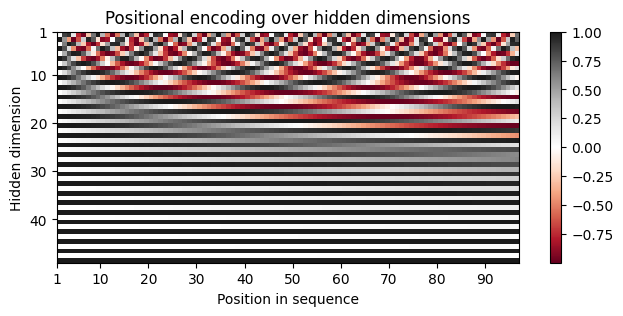

In [94]:
pos_embed_visual = Sinusoid(d_model=48, context_length=96)

P_visual = pos_embed_visual.P.squeeze().T.cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 3))
pos = ax.imshow(P_visual, cmap="RdGy", extent=(1, P_visual.shape[1] + 1, P_visual.shape[0] + 1, 1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_xticks([1] + [i * 10 for i in range(1, 1 + P_visual.shape[1] // 10)])
ax.set_yticks([1] + [i * 10 for i in range(1, 1 + P_visual.shape[0] // 10)])
plt.show()

The positional encodings are depicted through sine and cosine functions, each
varying in wavelength across the hidden dimensions, to uniquely represent each
position. By examining these functions within individual hidden dimensions, we
gain deeper insights into the encoding patterns. Here, we present a
visualization of the positional encodings across hidden dimensions $d = 0, 1,
2, 3$ for the initial $16$ sequence positions {cite}`lippe2023uvadlc`.

In [95]:
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_positional_encoding(pe: np.ndarray, block_size: int, figsize: Tuple[int, int] = (12, 4)) -> None:
    """Plot positional encoding for each hidden dimension.

    Args:
        pe: Positional encoding array.
        composer_block_size: Block size of the composer.
        figsize: Figure size for the plot.
    """
    sns.set_theme()
    fig, ax = plt.subplots(2, 2, figsize=figsize)
    ax = [a for a_list in ax for a in a_list]

    for i, a in enumerate(ax):
        a.plot(np.arange(1, block_size + 1), pe[i, :block_size], color=f'C{i}', marker="o", markersize=6, markeredgecolor="black")
        a.set_title(f"Encoding in hidden dimension d={i+1}")
        a.set_xlabel("Position in sequence", fontsize=10)
        a.set_ylabel("Positional encoding", fontsize=10)
        a.set_xticks(np.arange(1, 17))
        a.tick_params(axis='both', which='major', labelsize=10)
        a.tick_params(axis='both', which='minor', labelsize=8)
        a.set_ylim(-1.2, 1.2)

    fig.subplots_adjust(hspace=0.8)
    sns.reset_orig()
    plt.show()

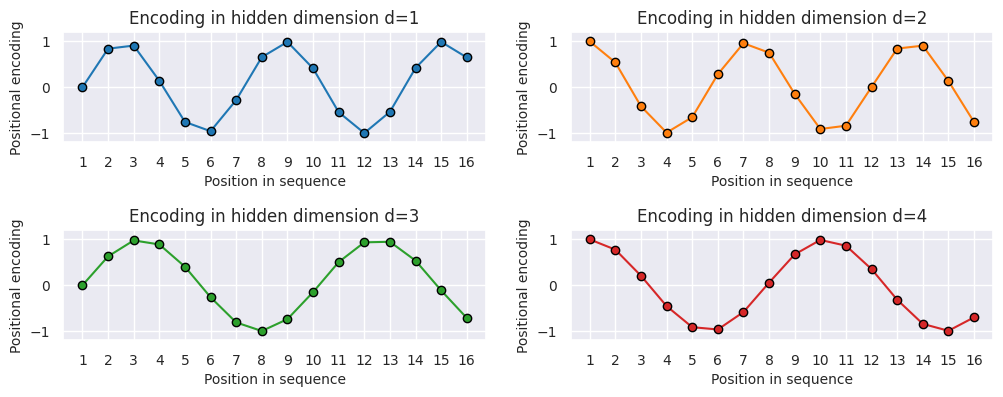

In [96]:
plot_positional_encoding(P_visual, 16)

As we can see, the patterns between the hidden dimension 1 and 2 only differ in
the starting angle. The wavelength is $2\pi$ , hence the repetition after
position 6 . The hidden dimensions 2 and 3 have about twice the wavelength {cite}`lippe2023uvadlc`.

### Positional Encodings via Embeddings

In practice, the positional encodings are learned as part of the GPT-2 {cite}`radford2019language`.
So we can replicate the same by using a `nn.Embedding` layer in PyTorch as in the token embeddings.

$\mathbf{W}_{p}$ is the positional embedding matrix. Each row of this matrix
corresponds to the embedding of a position in a sequence. This matrix is usually
of size $T \times D$, where $T$ is the maximum length of a sequence we allow in
the model, and $D$ is the dimension of the embedding space.

In other words, the $\mathbf{P}$ matrix introduced earlier has the same shape as
$\mathbf{W}_{p}$, and while the former is fixed, the latter is learned during
the training process.

In [97]:
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model: int, context_length: int) -> None:
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=context_length, embedding_dim=d_model)

    def forward(self, positions: torch.Tensor) -> torch.Tensor:
        return self.embedding(positions.to(device=self.embedding.weight.device))

In [98]:
generator = torch.Generator(device=composer.device)
generator.manual_seed(25)
seed_all(composer.seed, seed_torch=True, set_torch_deterministic=False)

pos_embed = PositionalEmbedding(d_model=composer.d_model, context_length=composer.block_size)
positions = torch.arange(start=0, end=composer.block_size, dtype=torch.long) # shape (t)
z0_pos_embed = pos_embed(positions)

z0_tok_embed_with_pos_embed = z0_tok_embed + z0_pos_embed
pprint(z0_tok_embed_with_pos_embed)

tensor([[[-0.9186,  0.6706,  1.4850, -0.4710],
│   │    [-0.9049,  2.3350,  3.0957, -0.1025],
│   │    [-0.7444, -0.7376,  2.6847, -0.9015],
│   │    [-0.4490, -1.7063, -2.5221,  0.3325],
│   │    [-1.4034, -2.2840,  0.4485,  0.6674],
│   │    [ 0.8796,  1.3154, -0.6523,  0.4923],
│   │    [ 2.3765,  1.7139,  2.1815, -0.0332],
│   │    [ 1.5345,  0.8230,  3.2535, -0.1055]]], grad_fn=<AddBackward0>)

To this end, we would have wrapped up the first two layers, where we first pass
an input sequence $\mathbf{x}$ through the token embedding layer to obtain the
token embeddings $\mathbf{Z} = \mathbf{W}_{e} \mathbf{x}$, and then add the
positional embeddings to the token embeddings to obtain the final embeddings.

The process to encode position into the embeddings is:

Given an input sequence $\mathbf{x} = \left(x_1, x_2, ..., x_{T}\right)$, where $x_t$ is
the token at position $t$ in the sequence, we have transformed the input
sequence into a sequence of token embeddings $\mathbf{Z}$, holding both the
static semantics and the positional information of the input sequence.

$$
\mathbf{Z} = \mathbf{W}_{e} \mathbf{x} + \mathbf{W}_{p} \in \mathbb{R}^{T \times D}
$$

And note this is only for $1$ sequence, and we can extend this to $\mathcal{B}$
sequences in a batch.

## Layer Normalization

### Definition

```{prf:definition} Layer Normalization
:label: decoder-layer-normalization

Given an input matrix $\mathbf{Z} \in \mathbb{R}^{T \times D}$, layer
normalization computes the normalized output matrix
$\bar{\mathbf{Z}} \in \mathbb{R}^{T \times D}$ as follows:

$$
\hat{\mathbf{Z}}_{t d}=\frac{\mathbf{Z}_{t d}-\mu_t}{\sqrt{\sigma_t^2+\epsilon}}
$$

$$
\mu_t \stackrel{\text { def }}{=} \frac{1}{D} \sum_{d=1}^D Z_{t d}, \quad \sigma_t^2 \stackrel{\text { def }}{=} \frac{1}{D} \sum_{d=1}^D\left(Z_{t d}-\mu_t\right)^2
$$

for $d=1, \ldots, D$, where $T$ is the number of tokens in the sequence, $D$ is
hidden dimension. Furthermore, the mean and variance are computed for each token
$\mathbf{Z}_{t} \in \mathbb{R}^{1 \times D}$ along the feature (embedding)
dimension across all positions, respectively. We add a small constant
$\epsilon>0$ to prevent division by zero and numerical stability.

You can think of each token $t=1, \ldots, T$ as a separate example, and
$\mathbf{Z}_{t}$ represents each row/token. We then compute the mean and
variance for each row/token and then apply the normalization to each row/token.
This process is repeated for each row/token in the input matrix $\mathbf{Z}$.
```

In [99]:
generator = torch.Generator(device=composer.device)
generator.manual_seed(25)
seed_all(composer.seed, seed_torch=True, set_torch_deterministic=False)

B, T, D = 2, 3, 4
embedding = torch.randn(B, T, D)

first_sequence_ = embedding[0]

first_sequence_mean = torch.empty_like(first_sequence_)
first_sequence_var = torch.empty_like(first_sequence_)

for index, token in enumerate(first_sequence_):

    first_sequence_mean[index, :] = torch.mean(token, dim=-1)
    first_sequence_var[index, :] = torch.var(token, dim=-1, unbiased=False)

pprint(first_sequence_mean)
pprint(first_sequence_var)

first_sentence_norm = (first_sequence_ - first_sequence_mean) / torch.sqrt(first_sequence_var)
pprint(first_sentence_norm)

layer_norm = nn.LayerNorm(normalized_shape=D, eps=0)

normalized_embedding = layer_norm(embedding)
pprint(normalized_embedding.shape)
pprint(normalized_embedding)

torch.testing.assert_close(first_sentence_norm, normalized_embedding[0], rtol=1e-5, atol=1e-5)

tensor([[-0.0398, -0.0398, -0.0398, -0.0398],
│   │   [-0.1287, -0.1287, -0.1287, -0.1287],
│   │   [-0.3987, -0.3987, -0.3987, -0.3987]])

tensor([[1.0230, 1.0230, 1.0230, 1.0230],
│   │   [0.4512, 0.4512, 0.4512, 0.4512],
│   │   [0.7168, 0.7168, 0.7168, 0.7168]])

tensor([[-1.1730,  0.0302,  1.5639, -0.4210],
│   │   [ 0.6077, -0.1970,  1.1190, -1.5296],
│   │   [ 1.3132,  0.0139,  0.1715, -1.4986]])

torch.Size([2, 3, 4])

tensor([[[-1.1730,  0.0302,  1.5639, -0.4210],
│   │    [ 0.6077, -0.1970,  1.1190, -1.5296],
│   │    [ 1.3132,  0.0139,  0.1715, -1.4986]],
│   │   
│   │   [[-0.3854,  1.6702, -0.9863, -0.2985],
│   │    [ 0.3328, -1.2407, -0.5304,  1.4383],
│   │    [-0.9720,  0.5154,  1.3870, -0.9305]]],
│      grad_fn=<NativeLayerNormBackward0>)

We see that indeed the assertion passed, and our calculations are correct. Note we must
set `unbiased=False` in the `torch.var` function to get the same result as the
`LayerNorm` function because we are using population variance formula.

We can further confirm below now the mean and variance close to 0 and 1 respectively.

In [100]:

mean = torch.mean(normalized_embedding, dim=-1)
std = torch.std(normalized_embedding, dim=-1)


print("\nExample of mean and std for a single sentence across embedding dimensions:")
print("Mean:", mean[0])
print("Standard deviation:", std[0])



Example of mean and std for a single sentence across embedding dimensions:
Mean: tensor([-3.7253e-08,  0.0000e+00, -5.9605e-08], grad_fn=<SelectBackward0>)
Standard deviation: tensor([1.1547, 1.1547, 1.1547], grad_fn=<SelectBackward0>)


### Learnable Affine Transformation

After normalization, it is common to apply a _learnable_ affine transformation (which is
scaling and shifting) to the normalized output to allow the model to adjust the
normalized output as needed. 

$$
\hat{\mathbf{Z}}_{t d}=\frac{\mathbf{Z}_{t d}-\mu_t}{\sqrt{\sigma_t^2+\epsilon}} \cdot \gamma + \beta
$$

where $\gamma$ and $\beta$ are learnable parameters of the same shape as
$\mathbf{Z}_{t}$, and they are learned during training. 

All in all, it is just taking each row in $\mathbf{Z}$, sum all $D$ elements in
the row, and then calculate the mean and variance. Then, we subtract the mean
from each element in the row, divide by the standard deviation, and then scale
and shift the result using $\gamma$ and $\beta$.

### Implementation

In [101]:
from typing import Optional, Tuple, Union

import torch
from torch import nn
from torch.types import _device, _dtype


class LayerNorm(nn.Module):
    __constants__ = ["normalized_shape", "eps", "elementwise_affine"]

    normalized_shape: Union[int, Tuple[int, ...]]
    eps: float
    elementwise_affine: bool

    def __init__(
        self,
        normalized_shape: Union[int, Tuple[int, ...]],
        eps: float = 1e-5,
        elementwise_affine: bool = True,
        device: Optional[Union[_device, str, None]] = None,
        dtype: Optional[_dtype] = None,
    ) -> None:
        super().__init__()
        factory_kwargs = {"device": device, "dtype": dtype}

        if isinstance(normalized_shape, int):
            normalized_shape = (normalized_shape,)
        self.normalized_shape = normalized_shape
        self.eps = eps
        self.elementwise_affine = elementwise_affine

        if self.elementwise_affine:
            self.gamma = nn.Parameter(torch.empty(self.normalized_shape, **factory_kwargs))  # type: ignore[arg-type]
            self.beta = nn.Parameter(torch.empty(self.normalized_shape, **factory_kwargs))  # type: ignore[arg-type]
        else:
            self.register_parameter("gamma", None)
            self.register_parameter("beta", None)

        self.reset_parameters()

    def reset_parameters(self) -> None:
        if self.elementwise_affine:
            nn.init.ones_(self.gamma)
            nn.init.zeros_(self.beta)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True, unbiased=False)
        if self.elementwise_affine:
            return self.gamma * (x - mean) / (std + self.eps) + self.beta
        return (x - mean) / (std + self.eps)

    def extra_repr(self) -> str:
        return "{normalized_shape}, eps={eps}, elementwise_affine={elementwise_affine}".format(**self.__dict__)


In [102]:
generator = torch.Generator(device=composer.device)
generator.manual_seed(25)
seed_all(composer.seed, seed_torch=True, set_torch_deterministic=False)

ln1 = LayerNorm(normalized_shape=composer.d_model, eps=1e-5, elementwise_affine=True)
z0_tok_embed_with_pos_embed_ln1 = ln1(z0_tok_embed_with_pos_embed)
pprint(z0_tok_embed_with_pos_embed_ln1)

ln1_pytorch = nn.LayerNorm(normalized_shape=composer.d_model, eps=1e-5, elementwise_affine=True)
z0_tok_embed_with_pos_embed_ln1_pytorch = ln1_pytorch(z0_tok_embed_with_pos_embed)
pprint(z0_tok_embed_with_pos_embed_ln1_pytorch)

torch.testing.assert_close(z0_tok_embed_with_pos_embed_ln1, z0_tok_embed_with_pos_embed_ln1_pytorch, rtol=1e-5, atol=1e-5)

tensor([[[-1.1744,  0.5068,  1.3684, -0.7009],
│   │    [-1.2140,  0.7421,  1.2014, -0.7295],
│   │    [-0.5436, -0.5391,  1.7304, -0.6478],
│   │    [ 0.5778, -0.5623, -1.3019,  1.2864],
│   │    [-0.6119, -1.3203,  0.8780,  1.0542],
│   │    [ 0.5074,  1.1037, -1.5886, -0.0225],
│   │    [ 0.8592,  0.1623,  0.6541, -1.6756],
│   │    [ 0.1286, -0.4499,  1.5262, -1.2049]]], grad_fn=<AddBackward0>)

tensor([[[-1.1744,  0.5068,  1.3684, -0.7009],
│   │    [-1.2140,  0.7421,  1.2014, -0.7295],
│   │    [-0.5436, -0.5391,  1.7304, -0.6478],
│   │    [ 0.5778, -0.5623, -1.3019,  1.2864],
│   │    [-0.6119, -1.3203,  0.8780,  1.0542],
│   │    [ 0.5075,  1.1037, -1.5886, -0.0225],
│   │    [ 0.8592,  0.1623,  0.6541, -1.6756],
│   │    [ 0.1286, -0.4499,  1.5262, -1.2049]]],
│      grad_fn=<NativeLayerNormBackward0>)

### Layer Norm Stabilises Activation Distributions

Besides the known fact that layer normalization enables convergence and provdies regularization {cite}`lippe2023uvadlc`,
it also stabilizes the distributions of activations {cite}`zhang2023dive`. 
Training deep neural networks are challenging, loss can easily be exploded or vanished, and the gradients can be unstable.
One simple way is to ensure each layer's activation has a similar distribution - the intuition is
that if each layer's activation has a similar distribution, then the gradients will also have a similar distribution, and this
will stabilize the training process. Layer normalization is one of the techniques that can help to achieve this.

## Residual Connection

I have written a more detailed post on the intuition of
[ResNet](https://gao-hongnan.github.io/gaohn-galaxy/deep_learning/computer_vision/modern_convolutional_neural_networks/resnets/concept.html)
which is heavily adapted from the chapter
[Residual Networks (ResNet) and ResNeXt](https://d2l.ai/chapter_convolutional-modern/resnet.html)
from the Dive into Deep Learning book.

For the sake of intuition, we can think of the residual connection as a way to
ensure that the original input to a layer is not lost as it passes through the
model layers.

-   Deep neural networks are known to suffer from the vanishing gradient
    problem, where gradients become increasingly small as they are
    backpropagated through the layers during training. Since we are
    backpropagating backwards, the earlier layers are therefore more susceptible
    to this problem. The weak gradient signal could often be close to $0$, and
    this could lead to the model not learning well. Consequently, we mitigate
    this problem by adding the original input to the output of the layer, so
    that the gradient signal has a direct path to flow through the network.

    -   Furthermore, Eugene Yan's blog post
        [Some Intuition on Attention and the Transformer](https://eugeneyan.com/writing/attention/)
        also highlighted that attention acting as a filtering mechanism may
        block information from passing through, directly resulting flat
        gradients as a small change to the inputs of the attention layer may not
        change the outputs that much. Skip (residual) connections help resolve
        this.

-   We will see later that Multi-Head Attention mechanism operates on a set of
    tokens, instead of over a sequence. We encode positional information into
    the tokens, but there is a risk that the positional information is lost in
    the multi-head attention layers. The residual connection helps to ensure
    that the positional information is not lost {cite}`lippe2023uvadlc`.
-   The other well known property of the residual connection is that it helps to
    learn the identity function. Perhaps the scenario is that the best thing a
    layer or a series of layer can learn is itself - and we don't actually want
    an update.

We quote the following from the Dive into Deep Learning book:

Consider $\mathcal{F}$, the class of functions that a specific network
architecture (together with learning rates and other hyperparameter settings)
can reach. That is, for all $f \in \mathcal{F}$ there exists some set of
parameters (e.g., weights and biases) that can be obtained through training on a
suitable dataset. Let us assume that $f^*$ is th "truth" function that we really
would like to find. If it is in $\mathcal{F}$, we are in good shape but
typically we will not b quite so lucky. Instead, we will try to find some
$f_{\mathcal{F}}^*$ which is our best bet within $\mathcal{F}$. For instance,
given a dataset with features $\mathbf{X}$ and labels $\mathbf{y}$, we might try
finding it by solving the following optimization problem:

$$
f_{\mathcal{F}}^* \stackrel{\text { def }}{=} \underset{f}{\operatorname{argmin}} L(\mathbf{X}, \mathbf{y}, f) \text { subject to } f \in \mathcal{F} .
$$

It is only reasonable to assume that if we design a different and more powerful
architecture $\mathcal{F}^{\prime}$ we should arrive at a better outcome. In
other words, we would expect that $f_{\mathcal{F}}^*$ is "better" than
$f_{\mathcal{F}}^*$. However, if $\mathcal{F} \nsubseteq \mathcal{F}^{\prime}$
there is no guarantee that this should even happen. In fact,
$f_{\mathcal{F}^{\prime}}^*$ might well be worse.

As illustrated by :numref: fig_functionclasses, for non-nested function classes,
a larger function class does not always move closer to the "truth" function
$f^*$. For instance, on the left of :numref: fig_functionclasses, though
$\mathcal{F}_3$ is closer to $f^*$ than $\mathcal{F}_1, \mathcal{F}_6$ moves
away and there is no guarantee that further increasing the complexity can reduce
the distance from $f^*$. With nested function classes where
$\mathcal{F}_1 \subseteq \ldots \subseteq \mathcal{F}_6$ on the right of
:numref: fig_functionclasses, we can avoid the aforementioned issue from the
non-nested function classes.

```{figure} ./assets/d2l-resnet-functionclasses.svg
---
name: d2l-resnet-functionclasses
---

For non-nested function classes, a larger (indicated by area) function class
does not guarantee we will get closer to the "truth" function $f^*$. This
does not happen for nested function classes.

**Image Credit:**
[8.6. Residual Networks (ResNet) and ResNeXt - Dive Into Deep Learing](https://d2l.ai/chapter_convolutional-modern/resnet.html)
```

### LayerNorm and Residual Connection

In our context, we would have the following:

$$
\begin{aligned}
\operatorname{AddNorm}(\mathbf{x}) &= \operatorname{LayerNorm}(\mathbf{x} + \operatorname{Sublayer}(\mathbf{x})) \\
\end{aligned}
$$

### Implementation of Residual Block and AddNorm

In [103]:
from typing import Callable

import torch
from torch import nn


class ResidualBlock(nn.Module):
    def forward(
        self,
        x: torch.Tensor,
        sublayer: Callable[[torch.Tensor], torch.Tensor],
    ) -> torch.Tensor:
        return x + sublayer(x)

class AddNorm(nn.Module):
    def __init__(self, feature_dim: int, dropout: float) -> None:
        super().__init__()
        # fmt: off
        self.dropout    = nn.Dropout(p=dropout, inplace=False)
        self.layer_norm = LayerNorm(normalized_shape=feature_dim, eps=1e-5, elementwise_affine=True)
        # fmt: on

    def forward(self, x: torch.Tensor, sublayer: Callable[[torch.Tensor], torch.Tensor]) -> torch.Tensor:
        """G(F(x) + x) where G = layer norm and F = sublayer"""
        # FIXME: GPT-2 should be x + self.dropout(sublayer(self.layer_norm(x)))
        output: torch.Tensor = self.layer_norm(x + sublayer(self.dropout(x)))
        return output

## Self-Attention

### Intuition of Attention Mechanism

Attention is not a new concept, and one of the most influencial papers came from
_Neural Machine Translation by Jointly Learning to Align and Translate_
{cite}`bahdanau2014neural`, a paper published during 2014. In the context of our
post, we would stick to one intuitive interpretation, that _the attention
mechanism describes a **weighted average** of (sequence) elements with the
weights **dynamically** computed based on an input query and elements’ keys_
{cite}`lippe2023uvadlc`. In other words, we want contextually relevant
information to be weighted more heavily than less relevant information. For
example, the sentence _the cat walks by the river bank_ would require the word
_bank_ to be weighted more heavily than the word _the_ when the word _cat_ is
being processed. The dynamic portion is also important because this allows the
model to adjust the weights based on an input sequence (note that the learned
weights are static but the interaction with the input sequence is dynamic). When
attending to the first token _cat_ in the sequence, we would want the token
_cat_ to be a **weighted average** of all the tokens in the sequence, including
itself. This is the essence of the self-attention mechanism.

### Token Embedding and Vector Representation Process

Given an input sequence $\mathbf{x} = \left(x_1, x_2, \ldots, x_T\right)$, where
$T$ is the length of the sequence, and each $x_t \in \mathcal{V}$ is a token in
the sequence, we use a generic embedding function $h_{\text{emb}}$ to map each
token to a vector representation in a continuous vector space:

$$
\begin{aligned} h_{\text{emb}} : \mathcal{V} &\rightarrow \mathbb{R}^{D} \\ x_t
&\mapsto \mathbf{z}_t \end{aligned}
$$

where $\mathcal{V}$ is the vocabulary of tokens (discrete space $\mathbb{Z}$),
and $D$ is the dimension of the embedding space (continuous space). The output
of the embedding function $h_{\text{emb}}$ is a sequence of vectors
$\mathbf{Z} = \left(\mathbf{z}_1, \mathbf{z}_2, \ldots, \mathbf{z}_T\right)$,
where each $\mathbf{z}_t \in \mathbb{R}^{D}$ is the vector representation of the
token $x_t$ in the sequence. As seen earlier, we represent the sequence of
vectors $\mathbf{Z}$ as a matrix $\mathbf{Z} \in \mathbb{R}^{T \times D}$, where
each row of the matrix represents the vector representation of each token in the
sequence.

### Queries, Keys, and Values

#### Database Analogy

Let's draw an analogy to understand the concept of queries, keys, and values in
the context of the attention mechanism. Consider a database $\mathcal{D}$
consisting of tuples of keys and values. For instance, the database
$\mathcal{D}$ might consist of tuples
`{("Zhang", "Aston"), ("Lipton", "Zachary"), ("Li", "Mu"), ("Smola", "Alex"), ("Hu", "Rachel"), ("Werness", "Brent")}`
with the last name being the key and the first name being the value
{cite}`zhang2023dive`. Operations on the database $\mathcal{D}$ can be performed
using queries $q$ that operate on the keys and values in the database. More
concretely, if our query is "Li", or more verbosely, "What is the first name
associated with the last name Li?", the answer would be "Mu" - the **key**
associated with the **query** "What is the first name associated with the last
name Li?" is "Li", and the **value** associated with the key "Li" is "Mu".
Furthermore, if we also allowed for approximate matches, we would retrieve
("Lipton", "Zachary") instead.

More rigorously, we denote
$\mathcal{D} \stackrel{\text { def }}{=}\left\{\left(\mathbf{k}_1, \mathbf{v}_1\right), \ldots\left(\mathbf{k}_m, \mathbf{v}_m\right)\right\}$
a database of $m$ tuples of _keys_ and _values_, as well as a query
$\mathbf{q}$. Then we can define the attention over $\mathcal{D}$ as

$$
\operatorname{Attention}(\mathbf{q}, \mathcal{D})
\stackrel{\operatorname{def}}{=} \sum_{t=1}^T \alpha\left(\mathbf{q},
\mathbf{k}_t\right) \mathbf{v}_t
$$

where
$\alpha\left(\mathbf{q}, \mathbf{k}_t\right) \in \mathbb{R}(t=1, \ldots, T)$ are
scalar attention weights {cite}`zhang2023dive`. The operation itself is
typically referred to as
[_attention pooling_](https://d2l.ai/chapter_attention-mechanisms-and-transformers/attention-pooling.html).
The term "attention" is used because this operation focuses specifically on
those terms that have a substantial weight, denoted as $\alpha$, meaning it
gives more importance to these terms. Consequently, the attention over
$\mathcal{D}$ generates a linear combination of values contained in the
database. In fact, this contains the above example as a special case where all
but one weight is zero. Why so? Because the query is an exact match for one of
the keys.

To illustrate why in the case of an exact match within a database the attention
weights ($\alpha$) are all zero except for one, let's use the attention formula
provided and consider a simplified example with vectors.

```{prf:example} Exact Match Scenario
:label: decoder-concept-attention-exact-match-scenario

Imagine a simplified database $\mathcal{D}$ consisting of 3 key-value pairs,
where each key $\mathbf{k}_t$ and the query $\mathbf{q}$ are represented as
vectors in some high-dimensional space, and the values $\mathbf{v}_t$ are also
vectors (or can be scalar for simplicity in this example). For simplicity, let's
assume our vectors are in a 2-dimensional space and represent them as follows:

-   Keys (representing $3$ keys in the database):
    -   $\mathbf{k}_1 = [1, 0]$,
    -   $\mathbf{k}_2 = [0, 1]$,
    -   $\mathbf{k}_3 = [1, 1]$
-   Values (corresponding to the keys):
    -   $\mathbf{v}_1 = [0.1, 0.9]$,
    -   $\mathbf{v}_2 = [0.2, 0.8]$,
    -   $\mathbf{v}_3 = [0.3, 0.7]$
-   Query (looking for an item/concept similar to $\mathbf{k}_1$):
    -   $\mathbf{q} = [1, 0]$

The attention weights $\alpha(\mathbf{q}, \mathbf{k}_t)$ indicate how similar or
relevant each key is to the query. In an exact match scenario, the similarity
calculation will result in a high value (e.g., $1$) when the query matches a key
exactly, and low values (e.g., $0$) otherwise. For simplicity, let's use a
simple matching criterion where the weight is $1$ for an exact match and $0$
otherwise:

-   $\alpha(\mathbf{q}, \mathbf{k}_1) = 1$ (since
    $\mathbf{q} =
    \mathbf{k}_1$, exact match)
-   $\alpha(\mathbf{q}, \mathbf{k}_2) = 0$ (since
    $\mathbf{q} \neq
    \mathbf{k}_2$, no match)
-   $\alpha(\mathbf{q}, \mathbf{k}_3) = 0$ (since
    $\mathbf{q} \neq
    \mathbf{k}_3$, no match)

Using the attention formula:


$$
\begin{aligned} \operatorname{Attention}(\mathbf{q}, \mathcal{D}) &=
\sum_{t=1}^3 \alpha(\mathbf{q}, \mathbf{k}_t) \mathbf{v}_t \\ &= (1 \cdot
[0.1, 0.9]) + (0 \cdot [0.4, 0.6]) + (0 \cdot [0.7, 0.3]) \\ &= [0.1, 0.9]
\end{aligned}
$$

This calculation shows that because the attention weights for $\mathbf{k}_2$ and
$\mathbf{k}_3$ are zero (due to no exact match), they don't contribute to the
final attention output. Only $\mathbf{k}_1$, which exactly matches the query,
has a non-zero weight (1), making it the sole contributor to the attention
result. This is a direct consequence of the query being an exact match for one
of the keys, leading to a scenario where "all but one weight is zero."
```

#### Queries, Keys, and Values in Attention Mechanism

The database example is a neat analogy to understand the concept of queries,
keys, and values in the context of the attention mechanism. To put things into
perspective, each token $x_t$ in the input sequence $\mathbf{x}$ emits three
vectors through projecting its corresponding token and positional embedding
output $\mathbf{z}_t$, a query vector $\mathbf{q}_t$, a key vector
$\mathbf{k}_t$, and a value vector $\mathbf{v}_t$. Consider the earlier example
_cat walks by the river bank_, where each word is a token in the sequence. When
we start to process the first token $\mathbf{z}_1$, _cat_, we would consider a
query vector $\mathbf{q}_1$, projected from $\mathbf{z}_1$, to be used to
interact with the key vectors $\mathbf{k}_t$ for $t \in \{1, 2, \ldots, T\}$, in
the sequence - determining how much _attention_ "cat" should pay to every other
token in the sequence (including itself). Consequently, it will also emit a key
vector $\mathbf{k}_1$ so that other tokens can interact with it. Subsequently,
the attention pooling will form a linear combination of the query vector
$\mathbf{q}_1$ with every other key vector $\mathbf{k}_t$ in the sequence,

$$
\alpha(\mathbf{q}_1, \mathbf{k}_t) \in \mathbb{R} = \mathbf{q}_1 \cdot
\mathbf{k}_t \quad \text{for } t \in \{1, 2, \ldots, T\}
$$

and each $\alpha(\mathbf{q}_1, \mathbf{k}_t)$ will indicate how much attention
the token "cat" should pay to the token at position $t$ in the sequence. We
would later see that we would add a softmax normalization to the attention
scores to obtain the final attention weights.

We would then use the attention scores $\alpha(\mathbf{q}_1, \mathbf{k}_t)$ to
create a weighted sum of the value vectors $\mathbf{v}_t$ to form the new
representation of the token "cat".

$$
\operatorname{Attention}(\mathbf{q}_1, \mathbf{k}_t, \mathbf{v}_t) =
\sum_{t=1}^T \alpha(\mathbf{q}_1, \mathbf{k}_t) \mathbf{v}_t
$$

Consequently, the first token must also emit a value vector $\mathbf{v}_1$. You
can think of the value vector as carrying the actual information or content that
will be aggregated based on the attention scores.

To reiterate, the output
$\operatorname{Attention}(\mathbf{q}_1, \mathbf{k}_t, \mathbf{v}_t)$ will be the
new representation of the token "cat" in the sequence, which is a weighted sum
of the value vectors $\mathbf{v}_t$ based on the attention scores
$\alpha(\mathbf{q}_1, \mathbf{k}_t)$ and now not only holds semantic and
positional information about the token "cat" itself but also contextual
information about the other tokens in the sequence. This allows the token "cat"
to have a better understanding of itself in the context of the whole sentence.
In this whole input sequence, the most ambiguous token is the token "bank" as it
can refer to a financial institution or a river bank. The attention mechanism
will help the token "bank" to understand its context in the sentence - likely
focusing more on the token "river" than the token "cat" or "walks" to understand
its context.

The same process will be repeated for each token in the sequence, where each
token will emit a query vector, a key vector, and a value vector. The attention
scores will be calculated for each token in the sequence, and the weighted sum
of the value vectors will be used to form the new representation of each token
in the sequence.

To end this off, we can intuitively think of the query, key and value as
follows:

-   **Query**: What does the token want to know? Maybe to the token _bank_, it
    is trying to figure out if it is a financial institution or a river bank.
    But obviously, when considering the token "bank" within such an input
    sequence, the query vector generated for "bank" would not actually ask "Am I
    a financial institution or a river bank?" but rather would be an abstract
    feature vector in a $D$ dimensional subspace that somehow captures the
    potential and context meanings of the token "bank" and once it is used to
    interact with the key vectors, it will help to determine later on how much
    attention the token "bank" should pay to the other tokens in the sequence.
-   **Key**: Carrying on from the previous point, if the query vector for the
    token "bank" is being matched with the key vectors of the other tokens in
    the sequence, the key "river" will be a good match for the query "bank" as
    it will help the token "bank" to understand its context in the sentence. In
    this subspace, the key vector for "river" will be a good match for the query
    because it is more of an "offering" service to the query vector, and it will
    know when it is deemed to be important to the query vector. As such, the
    vectors in this subspace are able to identify itself as important or not
    based on the query vector.

-   **Value**: The value vector is the actual information or content that will
    be aggregated based on the attention scores. If the attention mechanism
    determines that "river" is highly relevant to understanding the context of
    "bank" within the sentence, the value vector associated with "river" will be
    given more weight in the aggregation process. This means that the
    characteristics or features encoded in the "river" value vector
    significantly influence the representation of the sentence or the specific
    context being analyzed.

### Linear Projections

We have discussed the concept of queries, keys, and values but have not yet
discussed how these vectors are obtained. As we have continuously emphasized,
the query, key, and value vectors lie in a $D$-dimensional subspace, and they
encode various abstract information about the tokens in the sequence.
Consequently, it is no surprise that these vectors are obtained through linear
transformations/projections of the token embeddings $\mathbf{Z}$ using learned
weight matrices $\mathbf{W}^{\mathbf{Q}}$, $\mathbf{W}^{\mathbf{K}}$ and
$\mathbf{W}^{\mathbf{V}}$.

````{prf:definition} Linear Projections for Queries, Keys, and Values
:label: decoder-concept-linear-projections-queries-keys-values

In the self-attention mechanism, each token embedding
$\mathbf{z}_t \in \mathbb{R}^{D}$ is projected into a new context vector across
different **subspaces**. This projection is accomplished through three distinct
**linear transformations**, each defined by a unique weight matrix:


$$
\mathbf{W}^{\mathbf{Q}} \in \mathbb{R}^{D \times d_q}, \quad
\mathbf{W}^{\mathbf{K}} \in \mathbb{R}^{D \times d_k}, \quad
\mathbf{W}^{\mathbf{V}} \in \mathbb{R}^{D \times d_v}
$$

where $d_q, d_k, d_v \in \mathbb{Z}^+$ are the hidden dimensions of the
subspaces for the query, key, and value vectors, respectively.


```{prf:remark} Dimensionality of the Subspaces
:label: decoder-concept-linear-projections-queries-keys-values-remark

It is worth noting that this post is written in the context of understand
GPT models, and the dimensionality of the query, key, and value vectors are
the same and usually equal to the dimensionality of the token embeddings.
Thus, we may use $D$ interchangeably to indicate $d_k, d_v$ and $d_q$. This
is not always the case, as encoder-decoder models might have different
dimensionalities for the query, key, and value vectors. However, query and key
must have the same dimensionality for the dot product to work.
```

Each token embedding $\mathbf{z}_t$ is transformed into three vectors:

-   The **query vector** $\mathbf{q}_t$, representing what the token is looking
    for in other parts of the input,
-   The **key vector** $\mathbf{k}_t$, representing how other tokens can be
    found or matched,
-   The **value vector** $\mathbf{v}_t$, containing the actual information to be
    used in the output.

These transformations are formally defined as:

$$
\mathbf{q}_t = \mathbf{z}_t \mathbf{W}^{Q}, \quad \mathbf{k}_t =
\mathbf{z}_t \mathbf{W}^{K}, \quad \mathbf{v}_t = \mathbf{z}_t \mathbf{W}^{V}
$$

with each residing in $d_q, d_k, d_v$-dimensional subspaces, respectively.

Given an input sequence of $T$ tokens, the individual vectors for each token can
be stacked into matrices:

$$
\mathbf{Q} = \begin{bmatrix} \mathbf{q}_1 \\ \mathbf{q}_2 \\ \vdots \\
\mathbf{q}_T \end{bmatrix} \in \mathbb{R}^{T \times d_q}, \quad \mathbf{K} =
\begin{bmatrix} \mathbf{k}_1 \\ \mathbf{k}_2 \\ \vdots \\ \mathbf{k}_T
\end{bmatrix} \in \mathbb{R}^{T \times d_k}, \quad \mathbf{V} = \begin{bmatrix}
\mathbf{v}_1 \\ \mathbf{v}_2 \\ \vdots \\ \mathbf{v}_T \end{bmatrix} \in
\mathbb{R}^{T \times d_v}
$$

where each row of these matrices corresponds to the query, key, and value
vectors for each token, respectively.

These matrices are generated through simple matrix multiplication of the token
embedding matrix $\mathbf{Z} \in \mathbb{R}^{T \times D}$ with the weight
matrices
$\mathbf{W}^{\mathbf{Q}}, \mathbf{W}^{\mathbf{K}}$ and $\mathbf{W}^{\mathbf{V}}$:

$$
\mathbf{Q} = \mathbf{Z} \mathbf{W}^{\mathbf{Q}}, \quad \mathbf{K} = \mathbf{Z}
\mathbf{W}^{\mathbf{K}}, \quad \mathbf{V} = \mathbf{Z} \mathbf{W}^{\mathbf{V}}
$$
````

### Scaled Dot-Product Attention

#### Definition

```{prf:definition} Scaled Dot-Product Attention
:label: decoder-concept-scaled-dot-product-attention

The attention mechanism is a function that maps a set of queries, keys, and
values to an output, all of which are represented as matrices in a
$D$-dimensional space. Specifically, the function is defined as:

$$
\begin{aligned} \text{Attention}: \mathbb{R}^{T \times d_q} \times \mathbb{R}^{T
\times d_k} \times \mathbb{R}^{T \times d_v} & \rightarrow \mathbb{R}^{T \times
d_v} \\ (\mathbf{Q}, \mathbf{K}, \mathbf{V}) & \mapsto
\text{Attention}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) \end{aligned}
$$

where given a query matrix $\mathbf{Q} \in \mathbb{R}^{T \times d_q}$, a key
matrix $\mathbf{K} \in \mathbb{R}^{T \times d_k}$, and a value matrix
$\mathbf{V} \in \mathbb{R}^{T \times d_v}$, the attention mechanism computes the
the output matrix as follows:


$$
\text{Attention}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) =
\text{softmax}\left(\frac{\mathbf{Q}\mathbf{K}^{\top}}{\sqrt{d_k}}\right)\mathbf{V}
\in \mathbb{R}^{T \times d_v}
$$

where:

-   $\mathbf{Q}\mathbf{K}^{\top}$ represents the dot product between the query
    and key matrices, resulting in a matrix of scores that indicate the degree
    of alignment or relevance between each query and all keys.
-   $\sqrt{d_k}$ is a scaling factor used to normalize the scores, preventing them
    from becoming too large and ensuring a stable gradient during training. This
    scaling factor is particularly important as it helps maintain the softmax
    output in a numerically stable range {cite}`vaswani2017attention`.
-   $\text{softmax}(\cdot)$ is applied row-wise to convert scores into attention
    weights, ensuring that for each query, the weights across all keys sum up
    to 1. This normalization step allows the mechanism to effectively distribute
    focus across the keys according to their relevance to each query.
-   The resulting matrix of attention weights is then used to compute a weighted
    sum of the values in $\mathbf{V}$, producing the output matrix. This output
    represents a series of context vectors, each corresponding to a query and
    containing aggregated information from the most relevant parts of the input
    sequence as determined by the attention weights.
```

In what follows, we will break down the components of the attention mechanism
and explain how it works in detail:

-   What is Attention Scoring Function?
-   Why Softmax?
-   Why Scale by $\sqrt{d_k}$?
-   What is Context Vector?

#### Attention Scoring Function

In order to know which tokens in the sequence are most relevant to the current
token, we need to calculate the attention scores between the query and key
vectors. Consequently, we would need a scoring function that measures the
influence or contribution of the $j$-th position on the $i$-th position in the
sequence. This is achieved through the dot product between the query and key
vectors, the reasoning through a
[Gaussian kernel](https://en.wikipedia.org/wiki/Gaussian_filter) is rigorous and
provides a good
[intuition](https://d2l.ai/chapter_attention-mechanisms-and-transformers/attention-scoring-functions.html)
why we chose the dot product as the scoring function (other than the fact that
it is a measure of similarity).

```{prf:definition} Attention Scoring Function
:label: decoder-concept-attention-scoring-function

Define the attention scoring function $\alpha(\cdot)$ as a function
that calculates the relevance or influence of each position $t$ in the sequence
on position $i$, known as the attention scores. The attention scoring function
$\alpha(\cdot)$ is defined using the dot product between query and key
vectors, leveraging its property as a similarity measure.

$$
\begin{aligned} \alpha: \mathbb{R}^{d_q} \times \mathbb{R}^{d_k} & \rightarrow
\mathbb{R} \\ (\mathbf{q}, \mathbf{k}_t) & \mapsto \alpha(\mathbf{q},
\mathbf{k}_t) \end{aligned}
$$

Specifically, the function is expressed as:

$$
\alpha(\mathbf{q}, \mathbf{k}_t) = \langle \mathbf{q}, \mathbf{k}_t \rangle =
\mathbf{q} \cdot \mathbf{k}_t \in \mathbb{R}
$$

where:

-   $\mathbf{q}$ is a query vector representing in the sequence, seeking
    information or context.
-   $\mathbf{k}_t$ is the key vector representing the $t$-th position in the
    sequence, offering context or information.
-   $\langle \mathbf{q}, \mathbf{k}_t \rangle$ denotes the dot product between
    the query vector $\mathbf{q}$ and the key vector $\mathbf{k}_t$, which
    quantifies the level of similarity or alignment between the current position
    that $\mathbf{q}$ is at (say $i$-th) and $t$-th positions in the sequence.

The expression $\mathbf{q} \cdot \mathbf{k}_t$ is a scalar value that indicates
the degree of alignment or relevance between the query at $i$-th position and
the key at $t$-th position in the sequence. We would need to calculate the
attention scores for each token in the sequence with respect to the query vector
$\mathbf{q}$, and the key vectors $\mathbf{k}_t$ for
$t \in \{1, 2, \ldots, T\}$.

So this leads us to:

$$
\alpha(\mathbf{q}, \mathbf{K}) = \mathbf{q}\mathbf{K}^{\top} \in \mathbb{R}^{1
\times T}
$$

where

$$
\mathbf{K} = \begin{bmatrix} \mathbf{k}_1 \\ \mathbf{k}_2 \\ \vdots \\
\mathbf{k}_T \end{bmatrix} \in \mathbb{R}^{T \times d_k}
$$

is the matrix of key vectors for each token in the sequence, and the output
$\alpha(\mathbf{q}, \mathbf{K}) \in \mathbb{R}^{1 \times T}$ is a row
vector of attention scores for the query vector $\mathbf{q}$ with respect to
each key vector $\mathbf{k}_t$ for $t \in \{1, 2, \ldots, T\}$.

Lastly, there are $T$ such queries in the input sequence $\mathbf{Q}$, and we
can stack all the query vectors $\mathbf{q}_t$ into a matrix
$\mathbf{Q} \in \mathbb{R}^{T \times d_q}$ to calculate the attention scores for
all the queries in the sequence with respect to all the key vectors in the
sequence.

$$
\alpha(\mathbf{Q}, \mathbf{K}) = \mathbf{Q}\mathbf{K}^{\top} \in \mathbb{R}^{T
\times T}
$$

To this end, each row of the matrix $\mathbf{Q}\mathbf{K}^{\top}$ represents the
attention scores for each query vector at position $i$ in the sequence with
respect to all the key vectors in the sequence.
```

#### Scaling Down the Dot Product of Query and Key Vectors

```{prf:definition} Query and Key are Independent and Identically Distributed (i.i.d.)
:label: decoder-concept-query-key-iid

Under the assumption of the query $\mathbf{q}$ and key $\mathbf{k}_t$ are
_**independent and identically distributed**_ (i.i.d.) random variables with a
gaussian distribution of mean $0$ and variance $\sigma^2$:

$$
\mathbf{q} \overset{\mathrm{iid}}{\sim} \mathcal{N}(0, \sigma^2), \quad
\mathbf{k}_t \overset{\mathrm{iid}}{\sim} \mathcal{N}(0, \sigma^2)
$$
```

```{prf:definition} Variance of Dot Product
:label: decoder-concept-variance-dot-product

Given that $\mathbf{q} \overset{\mathrm{iid}}{\sim} \mathcal{N}(0, \sigma^2), \quad \mathbf{k}_t \overset{\mathrm{iid}}{\sim} \mathcal{N}(0, \sigma^2)$,
the variance of the dot product between the query vector $\mathbf{q}$ and the key
vector $\mathbf{k}_t$ is:

$$
\mathbb{V}[\mathbf{q} \cdot \mathbf{k}_t] = \sum*{i=1}^{d_k} \mathbb{V}[q_i
k*{ti}] = d_k \cdot \sigma^4.
$$
```

```{prf:proof}
The dot product between $\mathbf{q}$ and $\mathbf{k}_t$ can be expressed as the
sum of the products of their components:

$$\mathbf{q} \cdot \mathbf{k}_t = \sum_{i=1}^{d_k} q_i k_{ti},$$

where $q_i$ and $k_{ti}$ are the $i$-th components of $\mathbf{q}$ and
$\mathbf{k}_t$, respectively.

The variance of the sum of random variables (when these variables are
independent, which is our case since components are iid) is the sum of their
variances. The product $q_i k_{ti}$ is a new random variable, and its variance
can be calculated as follows for a single pair of components:

$$
\mathbb{V}[q_i k_{ti}] = \mathbb{E}[(q_i k_{ti})^2] - (\mathbb{E}[q_i
k_{ti}])^2.
$$

Given that $q_i$ and $k_{ti}$ are independent and both have mean 0:

$$\mathbb{E}[q_i k_{ti}] = \mathbb{E}[q_i] \cdot \mathbb{E}[k_{ti}] = 0.$$

The expectation of the square of the product is:


$$
\mathbb{E}[(q_i k_{ti})^2] = \mathbb{E}[q_i^2] \cdot \mathbb{E}[k_{ti}^2] =
\sigma^2 \cdot \sigma^2 = \sigma^4.
$$

Since $\mathbb{E}[q_i k_{ti}] = 0$, the variance of the product $q_i k_{ti}$ is
simply $\sigma^4$.

For the dot product, we sum across all $d_k$ components, and since the variance
of the sum of independent random variables is the sum of their variances:


$$
\mathbb{V}[\mathbf{q} \cdot \mathbf{k}_t] = \sum*{i=1}^{d_k} \mathbb{V}[q_i
k*{ti}] = d_k \cdot \sigma^4.
$$
```

We want to ensure that the variance of the dot product still remains the same as
the variance of the query and key vectors at $\sigma^2$ regardless of the vector
dimensions. To do so, we scale down the dot product by $\sqrt{d_k}$, which is
the square root of the dimensionality of the key vectors, this operation would
scale the variance of the dot product down by $\sqrt{d_k}^2 = d_k$ (since
variance of a scaled random variable is the square of the scale factor times the
original variance).

Now our variance would be $\sigma^4$ - but it is still not the same as the
variance of the query and key vectors. This is okay because the original paper
assume the variance $\sigma^2 = 1$ {cite}`vaswani2017attention`, and therefore
it does not matter since $\sigma^2 = \sigma^4$ when $\sigma^2 = 1$.

```{prf:definition} Attention Scoring Function with Scaling
:label: decoder-concept-attention-scoring-function-with-scaling

To this end, the updated scoring function is:

$$
\alpha(\mathbf{Q}, \mathbf{K}) = \frac{\mathbf{Q}\mathbf{K}^{\top}}{\sqrt{d_k}}
\in \mathbb{R}^{T \times T}
$$
```

Before we look into the reason why we scale down the dot product, let's first
complete the final block of the attention mechanism, which is the softmax
normalization.

#### Softmax

```{prf:definition} Attention Scores
:label: decoder-concept-attention-scores

Currently the attention scores $\alpha(\mathbf{Q}, \mathbf{K})$ are raw scores
that indicate the degree of alignment or relevance between each query and all
keys. They can be negative or positive, and they can be large or small. We
denote them as the raw **attention scores** $\alpha(\mathbf{Q}, \mathbf{K}) \in
\mathbb{R}^{T \times T}$.
```

```{prf:definition} Softmax Normalization and Attention Weights
:label: decoder-concept-softmax-normalization-attention-weights

It is common in deep learning to form a convex combination {cite}`zhang2023dive`
of the attention scores $\alpha(\mathbf{Q}, \mathbf{K})$ to obtain the
**attention weights**, denoted as $\text{softmax}(\alpha(\mathbf{Q}, \mathbf{K}))$, which
are non-negative and sum to $1$. This is achieved through the softmax
normalization function, which is defined as:

$$
\text{softmax}(\alpha(\mathbf{Q}, \mathbf{K})) = \frac{\exp(\alpha(\mathbf{Q},
\mathbf{K}))}{\sum_{t=1}^T \exp(\alpha(\mathbf{Q}, \mathbf{k}_t))} \in
\mathbb{R}^{T \times T}
$$

where:

-   $\exp(\cdot)$ is the exponential function, which is applied element-wise to
    the raw attention scores $\alpha(\mathbf{Q}, \mathbf{K})$.
-   The denominator is the sum of the exponentials of the raw attention scores
      across the $T$ keys, ensuring that the attention weights sum to $1$ for
      each query, allowing the mechanism to effectively distribute focus across
      the keys according to their relevance to each query.
```

The choice of softmax is a convenient choice, but not the only choice. However,
it is convenient because it is both _differentiable_, which is often a desirable
property for training deep learning models that are optimized using
gradient-based methods, and it is also _monotonic_, which means that the
**attention weights** are preserved exactly in the order as the raw **attention
scores**.

```{prf:definition} Attention Scoring Function with Scaling and Softmax
:label: decoder-concept-attention-scoring-function-with-scaling-softmax

To this end, our final attention scoring function is:

$$
\alpha(\mathbf{Q}, \mathbf{K}) =
\text{softmax}\left(\frac{\mathbf{Q}\mathbf{K}^{\top}}{\sqrt{d_k}}\right) \in
\mathbb{R}^{T \times T}
$$
```

#### Context Vector/Matrix

Consequently, we complete the walkthrough of the scaled dot-product attention
mechanism by calculating the context vector, which is the weighted sum of the
value vectors based on the attention weights obtained from the softmax
normalization.

```{prf:definition} Context Vector/Matrix
:label: decoder-concept-context-vector-matrix

Given the attention weights $\alpha(\mathbf{Q}, \mathbf{K})$ and the value
matrix $\mathbf{V}$, the context vector $\mathbf{C}$ is defined as the output
of the scaled dot-product attention mechanism:


$$
\mathbf{C} :=
\text{softmax}\left(\frac{\mathbf{Q}\mathbf{K}^{\top}}{\sqrt{d_k}}\right)\mathbf{V}
\in \mathbb{R}^{T \times d_v}
$$

where each row $\mathbf{c}_t$ of the context matrix $\mathbf{C}$ is the
new embedding of the token at position $t$ in the sequence, containing
not only the semantic and positional information of the token itself, but also
contextual information from the other tokens in the sequence.
```

#### Numerical Stability and Gradient Saturation

We can now revisit on the underlying reason why we scale down the dot product
$\mathbf{Q}\mathbf{K}^{\top}$ by $\sqrt{d_k}$.

First, the softmax function has all the desirable properties we want,
_smoothness_, _monotonicity_, and _differentiability_, but it is _sensitive_ to
large input values.

The softmax function is defined as follows for a given logit $z_i$ among a set
of logits $Z$:

$$
\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j} e^{z_j}}
$$

If the variance of the logits before applying softmax is too large (not scaled
down to a more manageable range), the exponential function $e^{z_i}$ can lead to
extremely large output values for any $z_i$ that is even slightly larger than
others in the set. This is due to the exponential function's rapid growth with
respect to its input value.

```{prf:remark} Gradient Saturation
:label: decoder-concept-gradient-saturation

-   **For one random element:** If one of the logits $z_i$ is significantly
    larger than the others (which is more likely when the variance of the logits
    is high), $e^{z_i}$ will dominate the numerator and denominator of the
    softmax function for this logit. This will cause the softmax output for this
    logit to approach 1, as it essentially overshadows all other $e^{z_j}$ terms
    in the denominator.

-   **For all others:** Simultaneously, the softmax outputs for all other logits
    $z_j$ (where $j \neq i$) will approach 0, because their $e^{z_j}$
    contributions to the numerator will be negligible compared to $e^{z_i}$ in
    the denominator. Thus, the attention mechanism would almost exclusively
    focus on the token corresponding to the dominant logit, ignoring valuable
    information from other parts of the input sequence.
-   Furthermore, the gradients through the softmax function will be very small
    (close to zero) for all logits except the dominant one, which can lead to
    _gradient saturation_ and even _vanishing gradients_ during training.
```

In [104]:
def softmax(z: torch.Tensor) -> torch.Tensor:
    return torch.exp(z) / torch.sum(torch.exp(z), axis=0)

# Without scaling: large inputs
logits_large = torch.tensor([10, 20, 30], dtype=torch.float32)
softmax_large = softmax(logits_large)

d_k = 512
scaling_factor = torch.sqrt(torch.tensor(d_k))
scaled_logits = logits_large / scaling_factor
softmax_scaled = softmax(scaled_logits)

print("Softmax without scaling:", softmax_large)
print("Softmax with scaling:", softmax_scaled)

Softmax without scaling: tensor([2.0611e-09, 4.5398e-05, 9.9995e-01])
Softmax with scaling: tensor([0.2010, 0.3126, 0.4864])


As we can see, a vector with large inputs can lead to a _sharpening_ effect on
the output of the softmax function, essentially causing the output to be too
peaky, converging to 1 for the largest input and 0 for the rest (one-hot).

```{prf:remark} Numerical Stability
:label: decoder-concept-numerical-stability

We know the importance of weight initialization in deep learning models,
this is because it dictates the variance of the activations and gradients
throughout the network. Without going into the theory, it is intuitive
to think that having similar variance across all layer activations is
a desirable property for numerical stability.
By doing so, the model helps to ensure that the gradients are stable
during backpropagation, avoiding the vanishing or exploding gradients problem
and enabling effective learning.

In the specific context of the attention mechanism, the variance of the dot
products used to calculate attention scores is scaled down by the factor
$\frac{1}{\sqrt{d_k}}$ to prevent softmax saturation. This allows each element
to have a chance to influence the model's learning, rather than having a single
element dominate because of the variance scaling with $d_k$.
```

#### Visualizing Variance of Dot Product

If we set $d_k = 512$, and mean $0$ with unit variance, we will see in action
that indeed the scaled dot product has a variance of $1$ while the unscaled dot
product has a variance of $512$, which coincides with our theoretical analysis.


In [105]:
seed_all(92, True, False)

# Set the dimensionality of the keys and queries
d_k = 512
# Set the batch size, number of heads, and sequence length
B, H, L = 4, 8, 32
# Standard deviation for initialization
sigma = 1.0

# Initialize Q and K with variance sigma^2
Q = torch.randn(B, H, L, d_k) * sigma
K = torch.randn(B, H, L, d_k) * sigma

# Calculate dot products without scaling
unscaled_dot_products = torch.matmul(Q, K.transpose(-2, -1))

# Calculate the variance of the unscaled dot products
unscaled_variance = unscaled_dot_products.var(unbiased=False)

# Apply the scaling factor 1 / sqrt(d_k)
scaled_dot_products = unscaled_dot_products / torch.sqrt(torch.tensor(d_k).float())

# Calculate the variance of the scaled dot products
scaled_variance = scaled_dot_products.var(unbiased=False)

print(f"Unscaled Variance: {unscaled_variance}")
print(f"Scaled Variance: {scaled_variance}")

# Apply softmax to the scaled and unscaled dot products
softmax_unscaled = torch.nn.functional.softmax(unscaled_dot_products, dim=-1)
softmax_scaled = torch.nn.functional.softmax(scaled_dot_products, dim=-1)

Unscaled Variance: 512.0117797851562
Scaled Variance: 1.0000230073928833


#### Projections Lead to Dynamic Context Vectors

From the start, we mentioned _the attention mechanism describes a **weighted
average** of (sequence) elements with the weights **dynamically** computed based
on an input query and elements’ keys_. We can easily see the **weighted
average** part through self-attention. The **dynamic** part comes from the fact
that the context vectors are computed based on the input query and its
corresponding keys. There should be no confusion that all the learnable weights
in this self-attention mechanism are the weight matrices
$\mathbf{W}^{\mathbf{Q}}$, $\mathbf{W}^{\mathbf{K}}$ and
$\mathbf{W}^{\mathbf{V}}$, but the dynamic is really because the scoring
function uses a dot product $\mathbf{Q}\mathbf{K}^{\top}$, which is **dynamic**
because it is solely decided by the full input sequence $\mathbf{x}$. Unlike
static embeddings, where the word "cat" will always have the same embedding
vector, the context vector for the word "cat" will be different in different
sentences because it now depends on the full input sequence $\mathbf{x}$.

Consequently, the projection of the token embeddings into the query and key
space is needed.

#### Implementation

In [106]:
class Attention(ABC, nn.Module):
    def __init__(self, dropout: float = 0.0) -> None:
        super().__init__()
        self.dropout = nn.Dropout(p=dropout, inplace=False)

    @abstractmethod
    def forward(
        self,
        query: torch.Tensor,
        key: torch.Tensor,
        value: torch.Tensor,
        mask: Optional[torch.BoolTensor] = None,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        raise NotImplementedError("The `forward` method must be implemented by the subclass.")


class ScaledDotProductAttention(Attention):
    def forward(
        self,
        query: torch.Tensor,
        key: torch.Tensor,
        value: torch.Tensor,
        mask: torch.BoolTensor | None = None,
        debug: bool = False,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        # fmt: off
        d_q               = query.size(dim=-1)

        attention_scores  = torch.matmul(query, key.transpose(dim0=-2, dim1=-1)) / torch.sqrt(torch.tensor(d_q).float())
        attention_scores  = attention_scores.masked_fill(mask == 0, float("-inf")) if mask is not None else attention_scores

        attention_weights = attention_scores.softmax(dim=-1)
        attention_weights = self.dropout(attention_weights)

        context_vector    = torch.matmul(attention_weights, value)
        # fmt: on
        if debug:
            return context_vector, attention_weights, attention_scores
        return context_vector, attention_weights

In [107]:
torch.manual_seed(42)

B, H, L, D = 4, 8, 32, 512  # batch size, head, context length, embedding dimension
Q = torch.rand(B, H, L, D)  # query
K = torch.rand(B, H, L, D)  # key
V = torch.rand(B, H, L, D)  # value

# Scaled Dot-Product Attention
attention = ScaledDotProductAttention(dropout=0.0)
context_vector, attention_weights = attention(Q, K, V)

assert context_vector.shape == (B, H, L, D)
assert attention_weights.shape == (B, H, L, L)
pprint(context_vector.shape)
pprint(attention_weights.shape)

# assert each row of attention_weights sums to 1
# assert each element of attention_weights is between 0 and 1
attention_weights_summed_over_sequences = attention_weights.sum(dim=-1)
assert torch.allclose(
    attention_weights_summed_over_sequences, torch.ones(B, H, L)
), "The attention weights distribution induced by softmax should sum to 1."
assert torch.all(
    (0 <= attention_weights) & (attention_weights <= 1)
), "All attention weights should be between 0 and 1."

torch.Size([4, 8, 32, 512])

torch.Size([4, 8, 32, 32])

#### Heatmap

In [108]:
def show_attention_heatmaps(
    attention_weights: torch.Tensor,
    xlabel: str = "Keys",
    ylabel: str = "Queries",
    show_title: bool = False,
    figure_kwargs: Optional[Dict[str, Any]] = None,
    plot_kwargs: Optional[Dict[str, Any]] = None,
) -> None:
    B, H, _, _ = attention_weights.shape

    if isinstance(attention_weights, torch.Tensor):
        attention_weights = attention_weights.detach().cpu().numpy()

    figure_kwargs = figure_kwargs or {"figsize": (15, 15), "sharex": True, "sharey": True, "squeeze": False}
    fig, axes = plt.subplots(B, H, **figure_kwargs)

    plot_kwargs = plot_kwargs or {"cmap": "viridis"}

    for b, (row_axes, attention_weight) in enumerate(zip(axes, attention_weights)):
        for h, (ax, head_attention) in enumerate(zip(row_axes, attention_weight)):
            pcm = ax.imshow(head_attention, **plot_kwargs)
            if b == B - 1:
                ax.set_xlabel(xlabel)  # Only the last batch will have the xlabel
            if h == 0:
                ax.set_ylabel(ylabel)  # Only the first head will have the ylabel

            if show_title:
                ax.set_title(f"Batch {b + 1}, Head {h + 1}")
    fig.colorbar(pcm, ax=axes, shrink=0.6)
    plt.show()

Connecting back to our earlier database query, the following identity matrix
would represent when the _query_ and the _key_ to be an exact match, indicated here
naively as if query is 0, then key is also 0, and so on. And thus
the weight matrix would have a diagonal of 1s and 0s elsewhere.

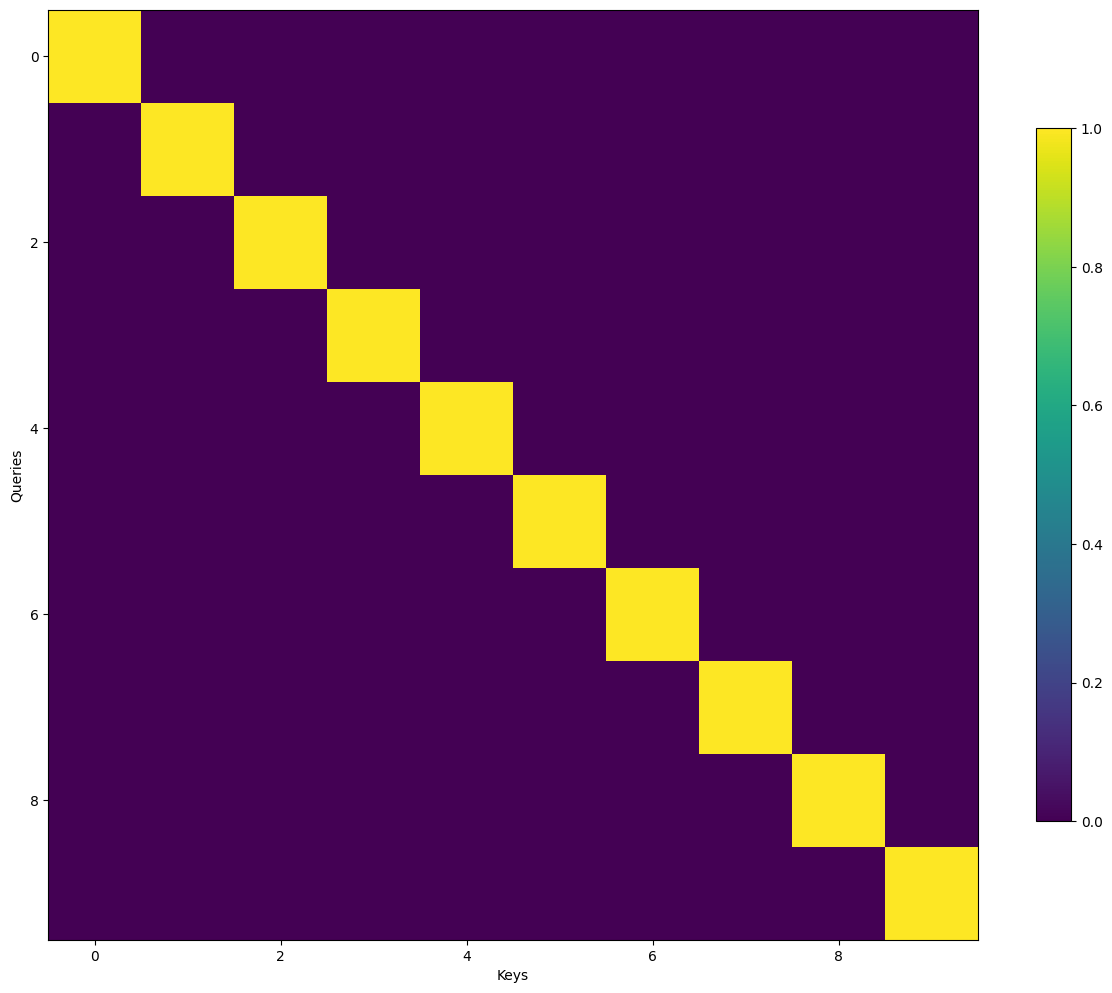

In [109]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_attention_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

#### Masked/Causal Self-Attention

In the context of GPT models, which is a decoder-only architecture, the
self-attention mechanism is often referred to as **masked self-attention** or
**causal attention**. The reason is that the attention mechanism is masked to
prevent information flow from future tokens to the current token. Given the
autoregressive and self-supervised nature of the GPT models, the prediction for
the current token should not be influenced by future tokens, as they are not
known during inference.


First, let's connect to our earlier example of `z_0_tok_embed_with_pos_embed` to
see the non-masked self-attention mechanism in action. 
We would create weights $\mathbf{W}^{\mathbf{Q}}$, $\mathbf{W}^{\mathbf{K}}$ and
$\mathbf{W}^{\mathbf{V}}$ and project the token embeddings into the query, key
and value space. We then pass the query, key and value matrices into the scaled
dot-product attention mechanism to obtain the context matrix $\mathbf{C}$
as well as the attention weights $\alpha(\mathbf{Q}, \mathbf{K})$.
Note since it is for only one sample, we would use lower case
letters instead.

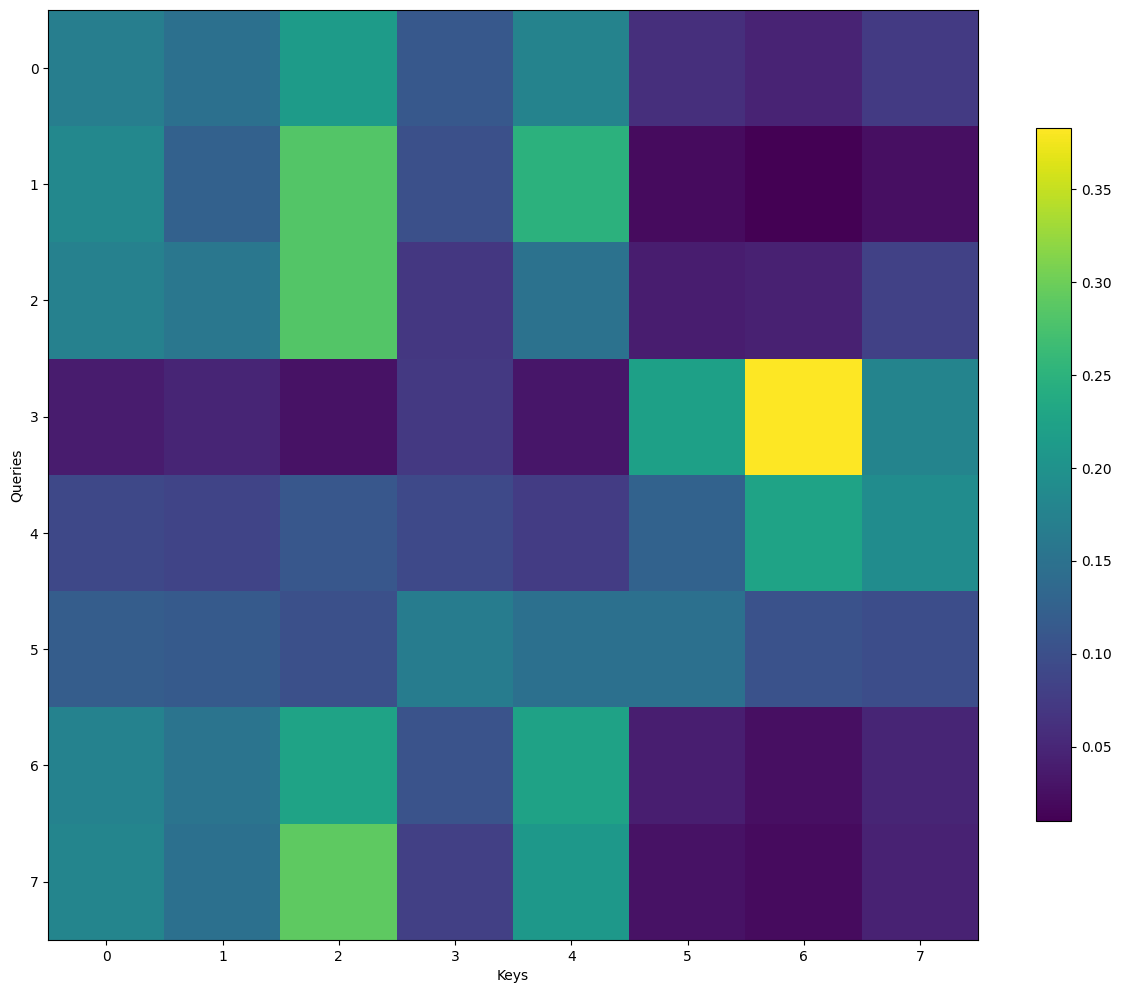

In [110]:
torch.manual_seed(42)
seed_all(composer.seed, seed_torch=True, set_torch_deterministic=False)

B, H, T, D = 1, 1, composer.block_size, composer.d_model  # batch size, head, context length, embedding dimension
W_q = nn.Linear(in_features=D, out_features=D, bias=False)
W_k = nn.Linear(in_features=D, out_features=D, bias=False)
W_v = nn.Linear(in_features=D, out_features=D, bias=False)

q0 = W_q(z0_tok_embed_with_pos_embed)
k0 = W_k(z0_tok_embed_with_pos_embed)
v0 = W_v(z0_tok_embed_with_pos_embed)

# Scaled Dot-Product Attention
attention = ScaledDotProductAttention(dropout=0.0)
context_vector, attention_weights = attention(q0, k0, v0)
attention_weights = attention_weights.reshape(B, H, T, T)

show_attention_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

However, there is just one problem. We are allowing the self-attention to attend
each token to all other tokens in the sequence, including itself. Since we have $T$
tokens in the sequence, each sub-sequence $x_{1:t}$ would look into the future
sub-sequence $x_{t+1:T}$, which is trivial now for the model to learn.

To fix this, we introduce the _mask_, where the mask effectively zeros out the
attention scores for the future tokens in the sequence. This would result in the usage
of an upper-triangular matrix for the attention scores, and the softmax would
then zero out the future tokens in the sequence.

tensor([[ True, False, False, False, False, False, False, False],
│   │   [ True,  True, False, False, False, False, False, False],
│   │   [ True,  True,  True, False, False, False, False, False],
│   │   [ True,  True,  True,  True, False, False, False, False],
│   │   [ True,  True,  True,  True,  True, False, False, False],
│   │   [ True,  True,  True,  True,  True,  True, False, False],
│   │   [ True,  True,  True,  True,  True,  True,  True, False],
│   │   [ True,  True,  True,  True,  True,  True,  True,  True]])

tensor([[ 0.4721,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
│   │   [ 0.9305,  0.5463,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
│   │   [ 0.6937,  0.6022,  1.1826,    -inf,    -inf,    -inf,    -inf,    -inf],
│   │   [-0.7824, -0.5645, -1.1218, -0.1659,    -inf,    -inf,    -inf,    -inf],
│   │   [-0.2023, -0.2518, -0.0057, -0.1813, -0.3737,    -inf,    -inf,    -inf],
│   │   [-0.1110, -0.1470, -0.2887,  0.2175,  0.0896,  0.0917,    -inf,    -inf],
│   │   [ 0.6619,  0.5281,  0.9173,  0.1447,  0.9101, -0.7911, -1.2993,    -inf],
│   │   [ 0.8410,  0.6451,  1.3262,  0.0369,  0.9972, -1.0329, -1.3433, -0.5124]],
│      grad_fn=<SqueezeBackward1>)

tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
│   │    [0.5949, 0.4051, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
│   │    [0.2822, 0.2576, 0.4602, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
│   │    [0.2080, 0.2586, 0.1481, 0.3853, 0.0000, 0.0000, 0.0000, 0.0000],
│   │    [0.1987, 0.1891, 0.2419, 0.2029, 0.1674, 0.0000, 0.0000, 0.0000],
│   │    [0.1507, 0.1453, 0.1261, 0.2092, 0.1841, 0.1845, 0.0000, 0.0000],
│   │    [0.1846, 0.1614, 0.2383, 0.1100, 0.2366, 0.0432, 0.0260, 0.0000],
│   │    [0.1790, 0.1471, 0.2907, 0.0801, 0.2092, 0.0275, 0.0201, 0.0462]]],
│      grad_fn=<SoftmaxBackward0>)

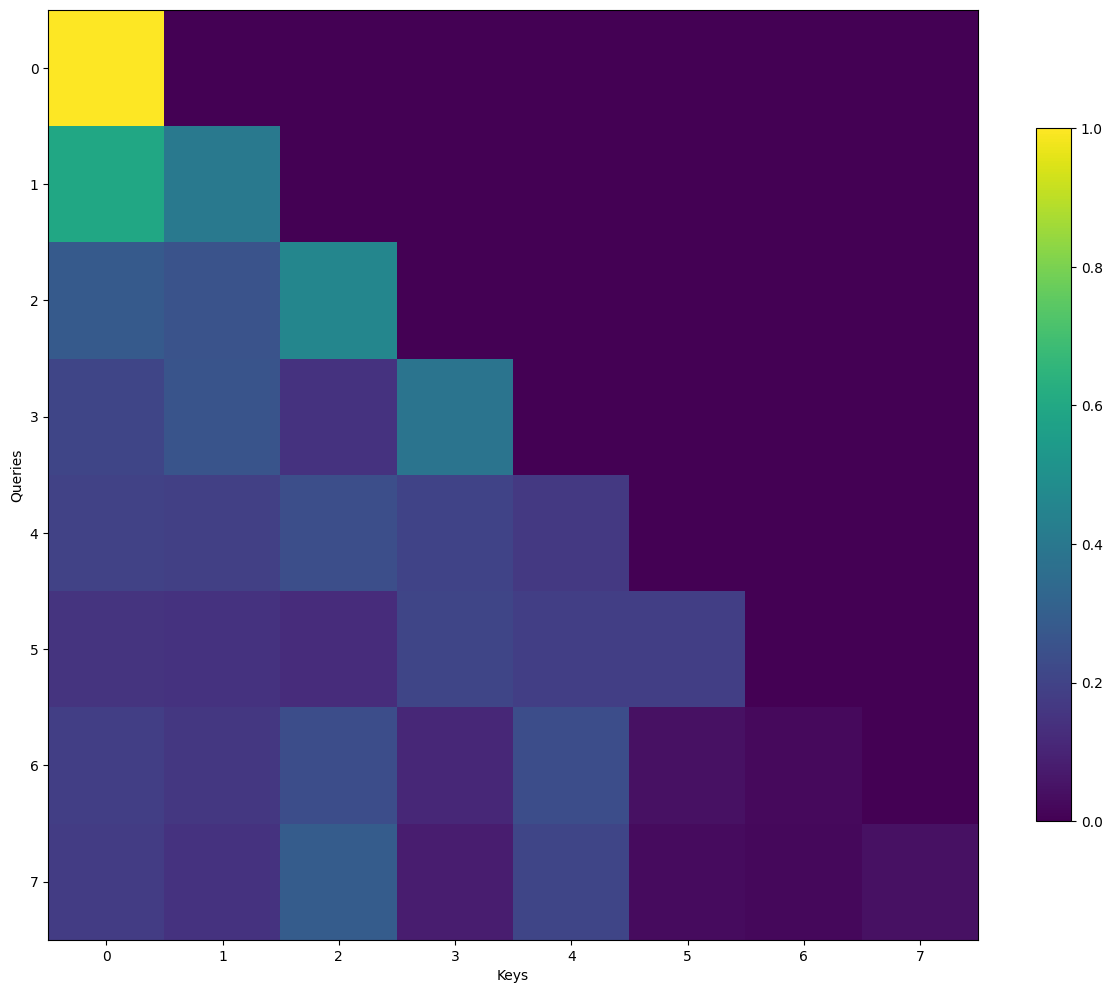

In [111]:
torch.manual_seed(42)
seed_all(composer.seed, seed_torch=True, set_torch_deterministic=False)

B, H, T, D = 1, 1, composer.block_size, composer.d_model  # batch size, head, context length, embedding dimension
W_q = nn.Linear(in_features=D, out_features=D, bias=False)
W_k = nn.Linear(in_features=D, out_features=D, bias=False)
W_v = nn.Linear(in_features=D, out_features=D, bias=False)

q0 = W_q(z0_tok_embed_with_pos_embed)
k0 = W_k(z0_tok_embed_with_pos_embed)
v0 = W_v(z0_tok_embed_with_pos_embed)

tril_mask = torch.tril(torch.ones((T, T), dtype=torch.bool))
pprint(tril_mask)

# Scaled Dot-Product Attention
attention = ScaledDotProductAttention(dropout=0.0)
context_vector, attention_weights, attention_scores = attention(q0, k0, v0, mask=tril_mask, debug=True)
pprint(attention_scores.squeeze(0).squeeze(0))
pprint(attention_weights)

attention_weights = attention_weights.reshape(B, H, T, T)
show_attention_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

In [112]:
x0_decoded = tokenizer.decode(x0.squeeze().detach().cpu().numpy())
pprint(x0_decoded)

' priest and clerk? well then, amen'

From the print logs and plots above, it is pretty clear how for one sequence,
the future mask is working. Consider our decoded first sample
`priest and clerk? well then, amen`. The result of $\mathbf{Q}\mathbf{K}^{\top}$
would be a matrix of attention weights of size $T \times T$. As we mentioned
earlier, if we do not mask, then for instance, the second row being the token
`and` would have information on every token, including `clerk`, `amen` etc. This
is considered _leakage_ of information.

So when we provide such a triangular mask:

$$
\text{mask} = \begin{bmatrix}
1 & 0 & 0 & \dots & 0 \\
1 & 1 & 0 & \dots & 0 \\
1 & 1 & 1 & \dots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & 1 & 1 & \dots & 1 \\
\end{bmatrix}
$$

and apply it to the attention scores, we would see that the attention scores
would have $-\infty$ for the future tokens,

$$
\begin{aligned}
\text{masked_attention_scores} &= \text{attention_scores} \odot \text{mask} + (1 - \text{mask}) \cdot (-\infty) \\
&= \begin{bmatrix}
q_1 \cdot k_1 & -\infty & -\infty & \dots & -\infty \\
q_2 \cdot k_1  & q_2 \cdot k_2 & -\infty & \dots & -\infty \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
q_T \cdot k_1 & q_T \cdot k_2 & q_T \cdot k_3 & \dots & q_T \cdot k_T \\
\end{bmatrix}
\end{aligned}
$$

and lastly applying the softmax function, we would see that the future tokens
would have a softmax output of $0$, a neat trick to ask the loss function to not
consider the future tokens in the sequence. We can even use `ignore_index` in
PyTorch's loss function like `nn.CrossEntropyLoss` to ignore the future tokens
via a given mask index.

$$
\begin{aligned}
\text{masked_attention_weights} &= \text{softmax}(\text{masked_attention_scores}) \\
&= \begin{bmatrix}
\text{softmax}(q_1 \cdot k_1) & 0 & 0 & \dots & 0 \\
\text{softmax}(q_2 \cdot k_1) & \text{softmax}(q_2 \cdot k_2) & 0 & \dots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
\text{softmax}(q_T \cdot k_1) & \text{softmax}(q_T \cdot k_2) & \text{softmax}(q_T \cdot k_3) & \dots & \text{softmax}(q_T \cdot k_T) \\
\end{bmatrix}
\end{aligned}
$$

#### Last Token has Full Context 

And finally, the `context_vector` is a matrix of size $T \times d_v$ where each
row is the context vector for each token in the sequence, containing not only
the semantic and positional information of the token itself, but also contextual
information from the preceding tokens in the sequence.

For example:

- The first token `priest` would have a context vector that contains information
from the token `priest` itself.
- The second token `and` would have a context vector that contains information
from the token `priest` and `and`.
- The third token `clerk` would have a context vector that contains information
from the token `priest`, `and` and `clerk`.
- ...
- The last token `amen` would have a context vector that contains information
from the token `priest`, `and`, `clerk`, ..., `amen`.

As a consequence, the last token would be the only token that has the full
context of the sequence, and this is why while generating text, we would only
need to use the context vector of the last token to generate the next token.

To this end, each sequence $\mathbf{x}$ is transformed to a $T \times d_v$

It is worth noting that one can connect back to the theory earlier on how one sequence
$\mathbf{x}$ is decomposed to a $T \times d_v$ matrix where $d_v = D$ when only one head is involved.
The difference is huge because each row of the embedding $\mathbf{z}$ before passing through attention
would only hold that single token $x_t$'s semantic and positional info without notion
of any other tokens in the sequence. Now, each row of the context vector $\mathbf{c}_t$
would hold the semantic and positional info of the token $x_t$ as well as the context
information from the preceding tokens in the sequence. 

Lastly, each sequence can be thought of having $T$ sub-samples, this is in line with our objective
to model the joint distribution of one sequence $\mathbf{x}$ - which is decomposed into $T$ conditional
probability.

### Computational Complexity of Self-Attention

It is easy to see that computing the dot product in self-attention quadratic
over its sequence length $T$. And naively, we would require
$\mathcal{O}(T^2 \cdot D)$ time to compute the self-attention on a sequence of
length $T$ and $D$-dimensional representations. We see a table listed below,
referenced from the paper _Attention is All You Need_
{cite}`vaswani2017attention`, with complexity per layer, the number of
sequential operations, and maximum path length. The complexity is measured by
the upper bound of the number of operations to perform, while the maximum path
length represents the maximum number of steps a forward or backward signal has
to traverse to reach any other position. The lower this length, the better
gradient signals can backpropagate for long-range dependencies
{cite}`lippe2023uvadlc`.

```{list-table} Master Theorem Cases
:header-rows: 1
:name: self-attention-complexity

*   - Layer Type
    - Complexity per Layer
    - Sequential Operations
    - Maximum Path Length
*   - Self-Attention
    - $\mathcal{O}(T^2 \cdot D)$
    - $\mathcal{O}(1)
    - \mathcal{O}(1)
*   - Recurrent
    - $\mathcal{O}(T \cdot D^2)$
    - $\mathcal{O}(T)$
    - $\mathcal{O}(T)$
*   - Convolutional
    - $\mathcal{O}(K \cdot T \cdot D^2)$
    - $\mathcal{O}(1)$
    - $\mathcal{O}(\log_K(T))$
*   - Self-Attention (restricted)
    - $\mathcal{O}(R \cdot T \cdot D)$
    - $\mathcal{O}(1)$
    - $\mathcal{O}\left(\frac{T}{R}\right)$
```

In the table, we have:

-   $T$ is the sequence length,
-   $D$ is the representation dimension,
-   $K$ is the kernel size of the convolution,
-   $R$ is the size of the neighborhood in restricted self-attention.

It is not easy to see that the parallel computation of self-attention is
favourable, why so? Because unlike recurrent, where we need to strictly follow
the sequence, in self-attention, we _simultaneously_ compute the attention
scores for all pairs of positions. This is why the maximum path length is
$\mathcal{O}(1)$ for self-attention, since the minimum number of processing
steps required to propagate information from any input position to any other
position is a constant, regardless of the sequence length, within the same
layer, whereas for recurrent, it is $\mathcal{O}(T)$ because information from
the first token in the sequence needs to pass through all the tokens to reach
the last token. It is worth noting that when $T >> D$, self-attention is more
computationally expensive than RNNs.


### More Intuition in Andrej Karpathy's Video

There's much more intuition in Andrej Karpathy's video on the [Let's Build GPT: from scratch, in code, spelled out](https://www.youtube.com/watch?v=kCc8FmEb1nY).
He mentions things like:

- Averaging past context with for loops, the weakest for of aggregation.
- Matrix multiply as weighted aggregation.
- Adding softmax to make it a weighted average.
- Attention as communication.
- Attention has no notion of space and operates over sets.
- There is no communication across batch dimension.

This [blog post](https://blog.matdmiller.com/posts/2023-06-10_transformers/notebook.html#previous-token-averages---building-intuition-for-self-attention)
implements what Andrej mentioned in the video.

## Multi-Head Attention

In practice, given the same set of queries, keys, and values we may want our
model to combine knowledge from different behaviors of the same attention
mechanism, such as capturing dependencies of various ranges (e.g., shorter-range
vs. longer-range) within a sequence. Thus, it may be beneficial to allow our
attention mechanism to jointly use different representation subspaces of
queries, keys, and values {cite}`zhang2023dive`.

What this implies is that the natural language is a complex space, and as
highlighted in the book _Speech and Language Processing_ by Jurafsky and Martin,
there are distinct semantic, syntactic and discourse relationships that can hold
between words in a sentence. For example, the verb "ate" in the sentence "The
cat ate the mouse" has a semantic relationship with the noun "cat" and "mouse",
and a syntactic relationship with the noun "the". It would be difficult for a
single head to hold all such representations over just a singled weighted
average, and this is where multi-head attention comes in.

Multi-head attention is a mechanism that allows the model to jointly attend to
information from different representation subspaces at different positions.

### Intuition

Eugene Yan's article
[Some Intuition on Attention and the Transformer](https://eugeneyan.com/writing/attention/)
provides good intuition on multi-head attention. We use his sample sequence
_"The chicken crossed the road carelessly"_ to illustrate the intuition.

-   One head might specifically capture the action-subject relationship, linking
    "crossed" with "chicken."
-   Another head could focus on the action-object relationship, associating
    "crossed" with "road."
-   Yet another head might explore the manner in which the action is performed,
    connecting "crossed" with "carelessly."

### Definition

The multi-head attention is a function that maps a query matrix
$\mathbf{Q} \in \mathbb{R}^{T \times d_q}$, a key matrix
$\mathbf{K} \in \mathbb{R}^{T \times d_k}$, and a value matrix
$\mathbf{V} \in \mathbb{R}^{T \times d_v}$ to an output matrix defined as
$\text{MultiHead}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) \in \mathbb{R}^{T \times d_v}$.
The function is defined as:

$$
\begin{aligned}
\text{for } h = 1, 2, \ldots, H: \\
\mathbf{Q}_h = \mathbf{Z} \mathbf{W}_{h}^{\mathbf{Q}} \quad \mathbf{K}_h = \mathbf{Z} \mathbf{W}_{h}^{\mathbf{K}} \quad \mathbf{V}_h = \mathbf{Z} \mathbf{W}_{h}^{\mathbf{V}} \\
\text{head}_h = \text{Attention}(\mathbf{Q}_h, \mathbf{K}_h, \mathbf{V}_h) \\
\mathbf{A} := \text{MultiHead}(\mathbf{Z}) = \left(\text{head}_1 \oplus \text{head}_2 \oplus \ldots \oplus \text{head}_H \right) \mathbf{W}^O
\end{aligned}
$$

where each $\text{head}_h$ is the context vector $\mathbf{C}_h$ obtained from
the $h$-th head of the self-attention mechanism. The $\oplus$ operator denotes
the concatenation operation that concatenates the context vectors
$\mathbf{C}_1,
\mathbf{C}_2, \ldots, \mathbf{C}_H$ along the feature dimension,
which essentially still result in the dimension $T \times D$. The $\mathbf{W}^O$
is a learnable weight matrix that projects the concatenated context vectors back
to the original dimensionality $D$.

Some other notations:

-   $H$ is the number of attention heads, which is a hyperparameter of the
    multi-head attention mechanism.
-   $\mathbf{W}_{h}^{\mathbf{Q}} \in \mathbb{R}^{D \times d_q}$: The learnable
    query weight matrix for the $h$-th head.
    -   Note that $d_q = \frac{D}{H}$, where $D$ is the hidden dimension of the
        token embeddings.
-   $\mathbf{W}_{h}^{\mathbf{K}} \in \mathbb{R}^{D \times d_k}$: The key weight
    matrix for the $h$-th head.
    -   Note that $d_k = \frac{D}{H}$, where $D$ is the hidden dimension of the
        token embeddings.
-   $\mathbf{W}_{h}^{\mathbf{V}} \in \mathbb{R}^{D \times d_v}$: The value
    weight matrix for the $h$-th head.
    -   Note that $d_v = \frac{D}{H}$, where $D$ is the hidden dimension of the
        token embeddings.
-   $\mathbf{Q}_h$, $\mathbf{K}_h$, and $\mathbf{V}_h$ are the query, key, and
    value matrices for the $h$-th head, respectively.
-   $\text{head}_h = \text{Attention}(\mathbf{Q}_h, \mathbf{K}_h, \mathbf{V}_h)$
    is the context vector $\mathbf{C}_h$ obtained from the $h$-th head of the
    self-attention mechanism.
-   $\oplus$ is just
    $\text{Concat}(\cdot)$, the concatenation operation that concatenates the head/context matrices $\mathbf{C}_1, \mathbf{C}_2, \ldots, \mathbf{C}_H$
    along the feature dimension, resulting in a matrix of context vectors of
    shape $\mathbb{R}^{T \times H \cdot d_v} = \mathbb{R}^{T \times D}$.
-   $\mathbf{W}^O \in \mathbb{R}^{d_v \times H \cdot d_v}$ is a learnable weight
    matrix that projects the concatenated context vectors back to the original
    dimensionality $D$.


Without the batch dimension $\mathcal{B}$, the output matrix $\mathbf{A}$ is
of shape $\mathbb{R}^{T \times D}$, where each row $\mathbf{a}_t$ of the output
matrix $\mathbf{A}$ is the new embedding of the token at position $t$ in the
sequence, containing not only the semantic and positional information of the
token itself, but also contextual information from the other tokens in the
sequence.

### Implementation

In [113]:
class MultiHeadedAttention(nn.Module):
    __slots__ = [
        "d_model",
        "d_k",
        "d_q",
        "d_v",
        "H",
        "W_Q",
        "W_K",
        "W_V",
        "W_O",
        "attention",
        "dropout",
        "context_vector",
        "attention_weights",
    ]

    def __init__(
        self,
        attention: Attention,
        H: int,
        d_model: int,
        dropout: float = 0.1,
        bias: bool = False,
    ) -> None:
        super().__init__()
        assert d_model % H == 0, "The number of heads must divide the embedding dimension."

        # fmt: off
        self.d_model   = d_model       # D
        self.d_k       = d_model // H  # stay true to notations
        self.d_q       = d_model // H
        self.d_v       = d_model // H

        self.H         = H             # number of heads

        # shadow my notations, actually they are of shape D x D.
        self.W_Q       = nn.Linear(self.d_model, self.d_q * self.H, bias=bias)  # D x D
        self.W_K       = nn.Linear(self.d_model, self.d_k * self.H, bias=bias)
        self.W_V       = nn.Linear(self.d_model, self.d_v * self.H, bias=bias)
        self.W_O       = nn.Linear(self.d_model, self.d_model, bias=bias)

        self.attention = attention
        self.dropout   = nn.Dropout(p=dropout, inplace=False)

        self.context_vector: torch.Tensor
        self.attention_weights: torch.Tensor

        # self._init_weights()
        # fmt: on

    def forward(
        self,
        query: torch.Tensor,
        key: torch.Tensor,
        value: torch.Tensor,
        mask: torch.BoolTensor | None = None,
    ) -> torch.Tensor:
        """
        Notations
        ---------
        B:      Batch size
        S or L: Source sequence length
        T or L: Target sequence length
        D:      Embedding dimension
        H:      Number of heads

        Parameters
        ----------
        query:  Although named as query, it is the embeddings `z` from the token_embedding + positional_embedding layer.
                type:  torch.Tensor
                shape: (B, S or T, D)
        key:    Although named as key, it is the embeddings `z` from the token_embedding + positional_embedding layer.
                type:  torch.Tensor
                shape: (B, S or T, D)
        value:  Although named as value, it is the embeddings `z` from the token_embedding + positional_embedding layer.
                type:  torch.Tensor
                shape: (B, S or T, D)
        mask:   Mask to be applied to the attention scores.
                type:  torch.BoolTensor
                shape: (B, 1, S or T, S or T)

        Returns
        -------
        O:  The output of the multi-headed attention mechanism.
            type:  torch.Tensor
            shape: (B, S or T, D)

        Variables
        ---------
        W_Q.weight (D, D)
        W_K.weight (D, D)
        W_V.weight (D, D)
        W_O.weight (D, D)
        """
        # fmt: off
        if mask is not None:
            assert mask.ndim     == 4, f"Mask should have 4 dimensions but got {mask.ndim}."
            assert mask.shape[0] == query.shape[0], ("Batch size of mask and query must match.")
            assert mask.shape[1] == 1, ("Mask should have shape (batch_size, 1, seq_len, seq_len).")
            assert mask.shape[2] == mask.shape[3] == query.shape[1], ("Mask should have shape (batch_size, 1, seq_len, seq_len).")


        Q = self.W_Q(query).contiguous() # Z @ W_Q -> LxD @ DxD = LxD -> [B, L, D]
        K = self.W_K(key).contiguous()   # Z @ W_K
        V = self.W_V(value).contiguous() # Z @ W_V

        Q = self.transpose_qkv(Q)        # splitting happens -> [B, H, L, D]
        K = self.transpose_qkv(K)
        V = self.transpose_qkv(V)

        # Attention
        self.context_vector, self.attention_weights = self.attention(Q, K, V, mask)
        context_vector_concat                       = self.reverse_transpose_qkv(self.context_vector)
        # fmt: on

        # mypy complains because it infers `O` as `Any` but it is actually a tensor.
        # You can either cast it to tensor or use `self.W_O.forward(context_vector_concat)`.
        O = self.W_O(context_vector_concat)  # context_vector_concat @ W_O -> LxD @ DxD = LxD
        return O  # type: ignore[no-any-return]

    def _init_weights(self) -> None:
        """See PyTorch's MultiHeadAttention code for reference."""
        # we assume _qkv_same_embed_dim is True
        nn.init.xavier_uniform_(self.W_Q.weight)
        nn.init.xavier_uniform_(self.W_K.weight)
        nn.init.xavier_uniform_(self.W_V.weight)
        nn.init.xavier_uniform_(self.W_O.weight)

    def transpose_qkv(self, q_or_k_or_v: torch.Tensor) -> torch.Tensor:
        """Transposition for parallel computation of multiple attention heads.
        Why does transpose allow parallel computation? So originally the shape of
        the query, key, and value is (B, L, D), and we want to split the D into H
        heads to become (B, L, H, D / H). But this is not the shape we want (could
        be due to efficiency reasons), so we transpose the shape to (B, H, L, D / H)
        so all heads can be computed in parallel (efficiently).

        Parameters
        ----------
        q_or_k_or_v: The query, key, or value tensor.
            type:  torch.Tensor
            shape: (B, L, D)

        Returns
        -------
        q_or_k_or_v: The transposed query, key, or value tensor.
            type:  torch.Tensor
            shape: (B, H, L, D / H)
        """
        # fmt: off
        # 1. q_or_k_or_v is shape (B, L, D)
        # 2. aim to make it of shape (B, L, H, D / H = d_qkv)
        batch_size, seq_len, _ = q_or_k_or_v.shape
        q_or_k_or_v            = q_or_k_or_v.view(batch_size, seq_len, self.H, self.d_model // self.H)

        # 3. switch H from 3rd to 2nd dimension, or in python swap 2nd to 1st dimension and 1st to 2nd dimension
        #    shape (B, H, L, D / H = d_qkv)
        q_or_k_or_v            = q_or_k_or_v.permute(0, 2, 1, 3)
        # fmt: on
        return q_or_k_or_v

    def reverse_transpose_qkv(self, q_or_k_or_v: torch.Tensor) -> torch.Tensor:
        """Reverse the transposition operation for concatenating multiple attention heads.

        Parameters
        ----------
        q_or_k_or_v: The query, key, or value tensor.
            type:  torch.Tensor
            shape: (B, H, L, D / H)

        Returns
        -------
        q_or_k_or_v: The transposed query, key, or value tensor.
            type:  torch.Tensor
            shape: (B, L, D)
        """
        # fmt: off
        # 1. q_or_k_or_v is shape (B, H, L, D / H = d_qkv)
        # 2. aim to make it of shape (B, L, H, D / H = d_qkv)
        q_or_k_or_v = q_or_k_or_v.permute(0, 2, 1, 3)

        # 3. Merge H and d_qkv into D
        batch_size, seq_len, _, _ = q_or_k_or_v.shape
        q_or_k_or_v = q_or_k_or_v.contiguous().view(batch_size, seq_len, self.d_model)
        # fmt: on
        return q_or_k_or_v

def construct_dummy_batch_future_masks(batch_size: int, seq_len: int) -> torch.BoolTensor:
    """Broadcast future mask from shape (L, L) to (B, L, L) then (B, 1, L, L)."""
    # Create a lower triangular mask for a single sequence
    future_mask = torch.tril(torch.ones((seq_len, seq_len), dtype=torch.bool), diagonal=0).to(torch.bool)
    future_mask = future_mask.contiguous()
    # broadcast future mask from shape (L, L) to (B, L, L)
    future_masks = future_mask.unsqueeze(0).expand(batch_size, -1, -1)
    # broadcast future mask from shape (B, L, L) to (B, 1, L, L)
    future_masks = future_masks.unsqueeze(1)
    return torch.BoolTensor(future_masks)

torch.Size([1, 8, 4])

torch.Size([1, 2, 8, 8])

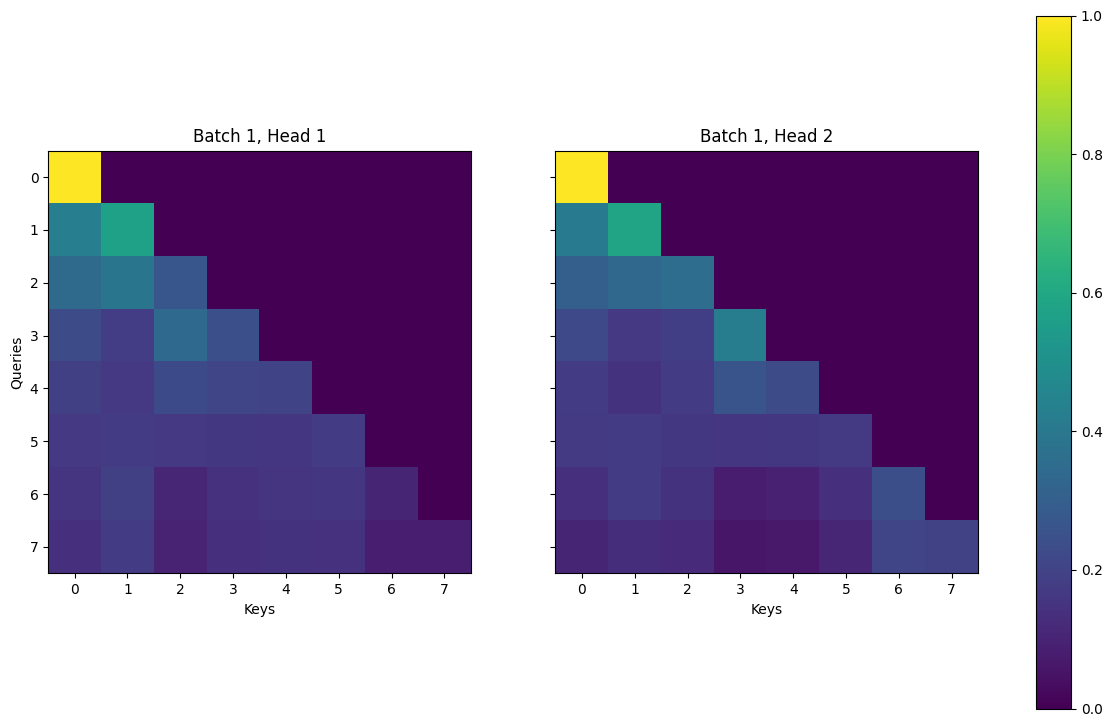

In [114]:
generator = torch.Generator(device=composer.device)
generator.manual_seed(25)
seed_all(composer.seed, seed_torch=True, set_torch_deterministic=False)

B, H, T, D = 1, 1, composer.block_size, composer.d_model  # batch size, head, context length, embedding dimension
W_q = nn.Linear(in_features=D, out_features=D, bias=False)
W_k = nn.Linear(in_features=D, out_features=D, bias=False)
W_v = nn.Linear(in_features=D, out_features=D, bias=False)

q0 = W_q(z0_tok_embed_with_pos_embed)
k0 = W_k(z0_tok_embed_with_pos_embed)
v0 = W_v(z0_tok_embed_with_pos_embed)
pprint(q0.shape)

causal_attention = ScaledDotProductAttention()
causal_mha = MultiHeadedAttention(attention=causal_attention, H=composer.H, d_model=composer.d_model, dropout=0.0)
tril_mask = construct_dummy_batch_future_masks(B, T)

A_BHL = causal_mha(q0, k0, v0, mask=tril_mask)

attention_weights = causal_mha.attention_weights
pprint(attention_weights.shape)
show_attention_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries', show_title=True)

### Permutation Invariance

Neural networks without the notion of sequence will be permutation invariant
with respect to the inputs and the multi-head attention mechanism is no
exception. If we ignore the the batch $\mathcal{B}$ dimension for now, then if
we switch two tokens in the sequence via $\text{permute}(\mathbf{Z})$, or more
concretely, say we swap $x_1$ and $x_2$ in the sequence, then the output of the
multi-head attention mechanism would be the same up to a permutation of the rows
($1 <-> 2$). This is why we would need the positional encoding to break the
permutation invariance.

Some extended ideas can be found in the chapter on
[Numerical Stability and Initialization](https://d2l.ai/chapter_multilayer-perceptrons/numerical-stability-and-init.html#breaking-the-symmetry),
from the book Dive into Deep Learning {cite}`zhang2023dive`.


### Applying LayerNorm and Residual Connections to Multi-Head Attention Output

Recall earlier on the discussion of using Layer Normalization (LayerNorm) on the
output of the Multi-Head Attention mechanism with residual connections.

$$
\begin{aligned}
\operatorname{AddNorm}(\mathbf{x}) &= \operatorname{LayerNorm}(\mathbf{x} + \operatorname{Sublayer}(\mathbf{x})) \\
\end{aligned}
$$

-   The Multi-Head Attention layer is the $\operatorname{Sublayer}(\cdot)$
    function. So $\text{MultiHead}(\cdot) := \operatorname{Sublayer}(\cdot)$.
-   The output from the Multi-Head Attention to be
    $\mathbf{A} \in \mathbb{R}^{T \times D}$, we would pass it to
    $\operatorname{LayerNorm}(\mathbf{A} + \text{MultiHead}(\mathbf{A}))$.


In [115]:
generator = torch.Generator(device=composer.device)
generator.manual_seed(25)
seed_all(composer.seed, seed_torch=True, set_torch_deterministic=False)

B, H, T, D = 1, 1, composer.block_size, composer.d_model  # batch size, head, context length, embedding dimension
W_q = nn.Linear(in_features=D, out_features=D, bias=False)
W_k = nn.Linear(in_features=D, out_features=D, bias=False)
W_v = nn.Linear(in_features=D, out_features=D, bias=False)

q0 = W_q(z0_tok_embed_with_pos_embed)
k0 = W_k(z0_tok_embed_with_pos_embed)
v0 = W_v(z0_tok_embed_with_pos_embed)

causal_attention = ScaledDotProductAttention()
causal_mha = MultiHeadedAttention(attention=causal_attention, H=composer.H, d_model=composer.d_model, dropout=0.0)
tril_mask = construct_dummy_batch_future_masks(B, T)

### AddNorm
add_norm_1 = AddNorm(feature_dim=composer.d_model, dropout=0.0)
z0_tok_embed_with_pos_embed_with_mha_and_addnorm1 = add_norm_1(z0_tok_embed_with_pos_embed, lambda z: causal_mha(z, z, z, mask=tril_mask))
pprint(z0_tok_embed_with_pos_embed_with_mha_and_addnorm1)

tensor([[[-1.1743,  0.7140,  1.2315, -0.7712],
│   │    [-1.1786,  0.9606,  1.0212, -0.8033],
│   │    [-0.4720, -0.5150,  1.7233, -0.7363],
│   │    [ 0.6594, -0.4229, -1.4141,  1.1776],
│   │    [-0.5698, -1.3424,  0.8061,  1.1061],
│   │    [ 0.5331,  1.0998, -1.5823, -0.0506],
│   │    [ 0.8590,  0.1289,  0.6803, -1.6681],
│   │    [ 0.1490, -0.4571,  1.5181, -1.2100]]], grad_fn=<AddBackward0>)

## Positionwise Feed-Forward Networks

The term "positionwise feed-forward network" (FFN) in the context of Transformer
models refers to a specific component that operates on the output of the
Multi-Head Attention mechanism. This component is called "positionwise" because
it applies the **same** feed-forward neural network (FFN) **independently** and
**identically** to each position in the sequence.

### Independent Processing

In the Transformer architecture, after the Multi-Head Attention mechanism
aggregates information from different positions in the sequence based on
attention scores, each element (or position) in the sequence has an updated
representation. The positionwise FFN then processes each of these updated
representations. However, rather than considering the sequence as a whole or how
elements relate to each other at this stage, the FFN operates on each position
separately. This means that for a sequence of length $T$, the same FFN is
applied $T$ times independently.

### Identical Application

The term "using the same FFN" signifies that the same set of parameters (weights
and biases) of the feed-forward neural network is used for each position in the
sequence. The rationale is that the transformation is consistent across all
sequence positions, so each element is transformed by the same learned function.
This ensures that any This uniform application ensures that while the FFN is
capable of complex transformations, the nature of the transformation is
consistent across all sequence positions.

### Definition

Typically, a positionwise FFN consists of two linear transformations with a
non-linear activation function in between. The general form can be represented
as follows.

Position-wise Feedforward Networks

Given an input matrix $M \in \mathbb{R}^{T \times D}$, the position-wise
feedforward network computes the output matrix
$M^{\prime} \in \mathbb{R}^{T \times D}$ as follows:

$$
M^{\prime}=\sigma_M\left(M \mathbf{W}^{\text{FF}}_1 + \mathbf{b}^{\text{FF}}_1\right) \mathbf{W}^{\text{FF}}_2 + \mathbf{b}^{\text{FF}}_2
$$

where:

-   $\mathbf{W}^{\text{FF}}_1 \in \mathbb{R}^{D \times d_{\text{ff}}}$ and
    $\mathbf{W}^{\text{FF}}_2 \in \mathbb{R}^{d_{\text{ff}} \times D}$ are
    learnable weight matrices.
-   $\mathbf{b}^{\text{FF}}_1 \in \mathbb{R}^{d_{\text{ff}}}$ and
    $\mathbf{b}^{\text{FF}}_2 \in \mathbb{R}^{D}$ are learnable bias vectors.
-   $\sigma_M$ is a non-linear activation function, such as the Gaussian Error
    Linear Unit (GELU) or the Rectified Linear Unit (ReLU).

### Projection to a Higher Dimension Space

We often used $d_{\text{ff}}$ to denote the dimensionality of the hidden layer
in the positionwise FFN. This tactic is not uncommon in deep learning training,
as a final layer after the backbone, and before the output layer, and is often
trying to project the incoming embeddings into a higher-dimensional space to
capture more complex representations, then project down to the output
dimensionality. In practice, multiplying $d_{\text{model}}$ by a constant factor
(e.g., 4) is a common choice for $d_{\text{ff}}$.


### Implementation

In [116]:
from typing import Optional

import torch
from torch import nn


class PositionwiseFeedForward(nn.Module):
    """
    Implements a Position-wise FeedForward Network (FFN) used in Transformer models.

    This module applies two linear transformations with a non-linear activation
    in between. It is often used after the multi-head self-attention layer
    in Transformer models.

    The naming convention for the linear layers ('context_fc' and 'context_projection') is inspired by
    the functionality within the Transformer architecture:

    - 'context_fc' (context fully connected): This layer expands the dimensionality
    of the input features, creating a richer representation. The expansion factor
    is often 4 in Transformer models, meaning the intermediate size is 4 times the
    size of the input/output dimensions.

    - 'context_projection' (context projection): This layer projects the expanded
    features back down to the original dimension, synthesizing the information
    processed by the 'context_fc' layer.

    """

    def __init__(
        self,
        d_model: int,
        d_ff: Optional[int] = None,
        activation: nn.Module = nn.ReLU(),
        dropout: float = 0.1,
        bias: bool = True,
    ) -> None:
        super().__init__()
        # fmt: off
        if d_ff is None:
            d_ff = 4 * d_model # typical value for d_ff in Transformer models

        self.ffn = nn.ModuleDict({
            'context_fc': nn.Linear(d_model, d_ff, bias=bias),
            'activation': activation,
            'context_projection': nn.Linear(d_ff, d_model, bias=bias),
            'dropout': nn.Dropout(p=dropout, inplace=False),

        })

        # self._init_weights()

    def _init_weights(self) -> None:
        """Initialize parameters of the linear layers."""
        nn.init.xavier_uniform_(self.ffn["context_fc"].weight)
        if self.ffn["context_fc"].bias is not None:
            nn.init.constant_(self.ffn["context_fc"].bias, 0)

        nn.init.xavier_uniform_(self.ffn["context_projection"].weight)
        if self.ffn["context_projection"].bias is not None:
            nn.init.constant_(self.ffn["context_projection"].bias, 0)

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        z = self.ffn["context_fc"](z)
        z = self.ffn["activation"](z)
        z = self.ffn["dropout"](z)
        z = self.ffn["context_projection"](z)
        return z

### Applying LayerNorm and Residual Connections to Positionwise FFN Output

We also apply Layer Normalization (LayerNorm) and residual connections to the
output of the positionwise FFN in a similar manner to the Multi-Head Attention.

In [117]:
generator = torch.Generator(device=composer.device)
generator.manual_seed(25)
seed_all(composer.seed, seed_torch=True, set_torch_deterministic=False)

ffn = PositionwiseFeedForward(d_model=composer.d_model, d_ff=composer.d_ff, activation=nn.GELU(approximate="tanh"), dropout=0.0)

### AddNorm
add_norm_2 = AddNorm(feature_dim=composer.d_model, dropout=0.0)
z0_tok_embed_with_pos_embed_with_mha_and_addnorm1_and_ffn_addnorm2 = add_norm_2(z0_tok_embed_with_pos_embed_with_mha_and_addnorm1, ffn)
pprint(z0_tok_embed_with_pos_embed_with_mha_and_addnorm1_and_ffn_addnorm2)

tensor([[[-1.1524,  1.2843,  0.6459, -0.7779],
│   │    [-1.0106,  1.5607,  0.1674, -0.7176],
│   │    [-0.0167, -0.9617,  1.6285, -0.6501],
│   │    [ 0.8038, -0.6207, -1.3064,  1.1234],
│   │    [-0.2816, -1.4653,  0.5214,  1.2255],
│   │    [ 0.8419,  0.5827, -1.6964,  0.2717],
│   │    [ 1.3571, -0.2673,  0.3190, -1.4089],
│   │    [ 0.7333, -0.8784,  1.2301, -1.0850]]], grad_fn=<AddBackward0>)

## Softmax Head

The softmax head is the final layer of the Transformer model that maps the
output of the positionwise FFN to the output vocabulary. The logits (without batch dimension) will have a shape
of $\mathbb{R}^{T \times V}$, where $V$ is the size of the output vocabulary.

We also add another layer of Layer Normalization (LayerNorm) to the output of the
positionwise FFN before the softmax head.

In [118]:
class Head(nn.Module):
    def __init__(self, d_model: int, vocab_size: int) -> None:
        super().__init__()
        self.linear = nn.Linear(d_model, vocab_size)

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        return self.linear(z)

In [119]:
ln_before_head = nn.LayerNorm(composer.d_model)

head = Head(d_model=composer.d_model, vocab_size=composer.vocab_size)
logits: torch.FloatTensor = head(ln_before_head(z0_tok_embed_with_pos_embed_with_mha_and_addnorm1_and_ffn_addnorm2))
pprint(logits.shape) # [B, T, V]

torch.Size([1, 8, 50257])

Each sub-sequence will be able to predict the next token in the sequence with
a probability distribution over the output vocabulary $\mathcal{V}$.

## Putting it all Together to form the GPT

### Patch Composer Configuration with Model Config

In [121]:
"""We use dataclass here for easy instantiating with hydra"""

from pydantic import BaseModel, Field
from torch import nn

class MultiHeadedAttentionConfig(BaseModel):
    attention: Attention
    d_model: int
    H: int
    dropout: float = 0.1

    class Config:
        """Pydantic config."""

        arbitrary_types_allowed = True


# TODO: add `field_validator` such that if `d_ff` is `None`, then `d_ff` is set to `4 * d_model`.
class PositionwiseFeedForwardConfig(BaseModel):
    d_model: int
    d_ff: int
    activation: nn.Module = Field(default=nn.GELU(approximate="tanh"))
    dropout: float = 0.1
    bias: bool = True

    class Config:
        """Pydantic config."""

        arbitrary_types_allowed = True


class AddNormConfig(BaseModel):
    feature_dim: int
    dropout: float


class DecoderBlockConfig(BaseModel):
    masked_self_attention_mha: MultiHeadedAttentionConfig
    feed_forward: PositionwiseFeedForwardConfig
    add_norm_1: AddNormConfig
    add_norm_2: AddNormConfig


class DecoderConfig(BaseModel):
    d_model: int
    vocab_size: int
    context_length: int  # NOTE: alias=max_seq_len,block_size
    num_decoder_blocks: int
    dropout: float
    decoder_block: DecoderBlockConfig


In [124]:
masked_self_attention_mha_config = MultiHeadedAttentionConfig(attention=ScaledDotProductAttention(), d_model=composer.d_model, H=composer.H, dropout=0.1)

feed_forward_config = PositionwiseFeedForwardConfig(d_model=composer.d_model, d_ff=composer.d_ff, activation=nn.GELU(approximate="tanh"), dropout=0.1, bias=True)

add_norm_config_1 = AddNormConfig(feature_dim=composer.d_model, dropout=0.1)
add_norm_config_2 = AddNormConfig(feature_dim=composer.d_model, dropout=0.1)

# Create DecoderBlockConfig
decoder_block_config = DecoderBlockConfig(
    masked_self_attention_mha=masked_self_attention_mha_config,
    feed_forward=feed_forward_config,
    add_norm_1=add_norm_config_1,
    add_norm_2=add_norm_config_2,
)

# Create the overall DecoderConfig
model_config = DecoderConfig(
    d_model=composer.d_model,
    vocab_size=composer.vocab_size,
    context_length=composer.block_size,
    num_decoder_blocks=1,
    dropout=0.1,
    decoder_block=decoder_block_config,
)

In [125]:
# patch Composer

composer.model_config = model_config
pprint(composer.model_config)

DecoderConfig(
│   d_model=4,
│   vocab_size=50257,
│   context_length=8,
│   num_decoder_blocks=1,
│   dropout=0.1,
│   decoder_block=DecoderBlockConfig(
│   │   masked_self_attention_mha=MultiHeadedAttentionConfig(
│   │   │   attention=ScaledDotProductAttention(
  (dropout): Dropout(p=0.0, inplace=False)
),
│   │   │   d_model=4,
│   │   │   H=2,
│   │   │   dropout=0.1
│   │   ),
│   │   feed_forward=PositionwiseFeedForwardConfig(
│   │   │   d_model=4,
│   │   │   d_ff=4,
│   │   │   activation=GELU(approximate='tanh'),
│   │   │   dropout=0.1,
│   │   │   bias=True
│   │   ),
│   │   add_norm_1=AddNormConfig(feature_dim=4, dropout=0.1),
│   │   add_norm_2=AddNormConfig(feature_dim=4, dropout=0.1)
│   )
)

### Decoder Blocks

The decoder block consists of the following transformations in pseudo-code:

```python
z = z + self.attn(self.ln_1(z))
z = z + self.mlp(self.ln_2(z))
```

Essentially, we take the embeddings output from the token and positional
layers, and go through the following:

```python
z -> LayerNorm(z) -> MultiHeadAttention(LayerNorm(z)) -> z + MultiHeadAttention(LayerNorm(z))
```

then we pass the output through the positionwise FFN, abbreivate `z + MultiHeadAttention(LayerNorm(z))` as `z_mha`:

```python
z_mha -> LayerNorm(z_mha) -> PositionwiseFFN(LayerNorm(z_mha)) -> z_mha + PositionwiseFFN(LayerNorm(z_mha))
```

It is worth noting that my implementation of `AddNorm` is different from the GPT-2 paper, with 
`self.layer_norm(x + sublayer(self.dropout(x)))` instead of `x + sublayer(self.layer_norm(x))`.
Both works, but the former is the one mentioned in the GPT-2 paper.

In [135]:
class GPTDecoderBlock(nn.Module):
    """GPTDecoderBlock focuses on masked self-attention and feed-forward layers.

    The architecture follows the GPT-style decoder, which only has masked
    self-attention and position-wise feed-forward layers, omitting the
    encoder-decoder cross-attention.
    """

    def __init__(self, config: DecoderConfig) -> None:
        super().__init__()
        # fmt: off
        self.masked_self_attention_mha = MultiHeadedAttention(**config.decoder_block.masked_self_attention_mha.model_dump(mode="python"))
        self.feed_forward              = PositionwiseFeedForward(**config.decoder_block.feed_forward.model_dump(mode="python"))
        self.add_norm_1                = AddNorm(**config.decoder_block.add_norm_1.model_dump(mode="python"))
        self.add_norm_2                = AddNorm(**config.decoder_block.add_norm_2.model_dump(mode="python"))
        # fmt: on

    def forward(
        self,
        z: torch.Tensor,  # that's tgt in torch code base
        *,
        target_masks: torch.BoolTensor,  # that's tgt_mask in torch code base
    ) -> torch.Tensor:
        z = self.add_norm_1(
            z,
            lambda z: self.masked_self_attention_mha(query=z, key=z, value=z, mask=target_masks),
        )
        z = self.add_norm_2(z, self.feed_forward)
        return z

### Decoder

In [136]:
from typing import cast, overload, Type

import torch
from torch import nn
from typing_extensions import override, TypeAlias

class _NotGiven:

    _instance: _NotGiven | None = None

    def __new__(cls: Type[_NotGiven]) -> _NotGiven:  # noqa: PYI034
        if cls._instance is None:
            cls._instance = super(_NotGiven, cls).__new__(cls)  # noqa: UP008
        return cls._instance

    def __bool__(self) -> Literal[False]:
        """
        This method is used to define the boolean value of an instance of `_NotGiven`.
        By returning `False`, it allows `_NotGiven` to be used in boolean contexts (like
        `if` statements) to signify the absence of a value. This is especially useful
        for checking if an argument was provided or not in a function.
        """
        return False

    @override
    def __repr__(self) -> Literal["NOT_GIVEN"]:
        return "NOT_GIVEN"

    def __setattr__(self, key: str, value: Any) -> None:
        raise AttributeError(f"{self.__class__.__name__} instances are immutable")

    def __delattr__(self, key: str) -> None:
        raise AttributeError(f"{self.__class__.__name__} instances are immutable")


NOT_GIVEN = _NotGiven()
NotGiven: TypeAlias = _NotGiven


def construct_dummy_batch_target_padding_masks(batch_size: int, seq_len: int) -> torch.BoolTensor:
    """Construct a dummy batch of target padding masks of shape (B, 1, L, L) which
    assumes there is no padding token involved."""

    return torch.BoolTensor(torch.ones((batch_size, 1, seq_len, seq_len), dtype=torch.bool))


class BaseDecoder(nn.Module, ABC):
    """
    Abstract base class for a decoder in a transformer-like architecture.
    """

    def __init__(
        self,
        config: DecoderConfig,
    ) -> None:
        super().__init__()
        self.config = config

    @abstractmethod
    def forward(
        self,
        input_tokens: torch.LongTensor,
        *,  # force keyword only arguments to prevent errors
        target_padding_masks: torch.BoolTensor | NotGiven = NOT_GIVEN,
        future_masks: torch.BoolTensor | NotGiven = NOT_GIVEN,
        encoder_hidden_states: torch.Tensor | NotGiven = NOT_GIVEN,  # that's memory in torch code base
        encoder_hidden_states_masks: torch.BoolTensor | NotGiven = NOT_GIVEN,  # that's memory_mask in torch code base
    ) -> torch.FloatTensor:
        ...

    def _init_weights(self, module: nn.Module) -> None:
        """Initializes weights of the given module using Xavier uniform initialization."""
        for p in module.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

# NOTE: seq_len <= context_length == max_seq_len
class GPTDecoder(BaseDecoder):
    def __init__(self, config: DecoderConfig) -> None:
        super().__init__(config)
        # fmt: off
        self.d_model       : int           = config.d_model
        self.tok_embed     : nn.Embedding  = nn.Embedding(config.vocab_size, config.d_model)
        self.pos_embed     : nn.Parameter  = nn.Parameter(torch.zeros(1, config.context_length, config.d_model))
        self.decoder_blocks: nn.ModuleList = nn.ModuleList([GPTDecoderBlock(config) for _ in range(config.num_decoder_blocks)]) # PyTorch did not make ModuleList a proper container, maybe open a PR to make it inherit Generic[T]???

        self.dropout       : nn.Dropout    = nn.Dropout(config.dropout)
        self.layer_norm    : nn.LayerNorm  = nn.LayerNorm(config.d_model)
        self.head          : nn.Linear     = nn.Linear(config.d_model, config.vocab_size)  # last layer
        # fmt: on

        self.apply(self._init_weights)

        # apply special scaled init to the residual projections, per GPT-2 paper
        for parameter_name, parameter in self.named_parameters():
            if parameter_name.endswith("context_projection.weight"):
                mean = 0.0
                std_dev = 0.02 / torch.sqrt(torch.tensor(2 * config.num_decoder_blocks, dtype=torch.float))
                torch.nn.init.normal_(parameter, mean=mean, std=std_dev)

    @property
    def total_trainable_parameters(self) -> int:
        """Returns the number of trainable parameters in the model."""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    @property
    def total_parameters(self) -> int:
        """Returns the total number of parameters in the model, including non-trainable."""
        return sum(p.numel() for p in self.parameters())

    @override
    def _init_weights(self, module: nn.Module) -> None:
        normal_init_modules = (nn.Linear, nn.Embedding)
        if isinstance(module, normal_init_modules):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if hasattr(module, "bias") and module.bias is not None:
                torch.nn.init.zeros_(module.bias)

    @overload
    def create_target_masks(
        self, batch_size: int, seq_len: int, target_padding_masks: torch.BoolTensor, future_masks: torch.BoolTensor
    ) -> torch.BoolTensor:
        ...

    @overload
    def create_target_masks(
        self, batch_size: int, seq_len: int, target_padding_masks: torch.BoolTensor, future_masks: NotGiven
    ) -> torch.BoolTensor:
        ...

    @overload
    def create_target_masks(
        self, batch_size: int, seq_len: int, target_padding_masks: NotGiven, future_masks: torch.BoolTensor
    ) -> torch.BoolTensor:
        ...

    @overload
    def create_target_masks(
        self, batch_size: int, seq_len: int, target_padding_masks: NotGiven, future_masks: NotGiven
    ) -> torch.BoolTensor:
        ...

    def create_target_masks(
        self,
        batch_size: int,
        seq_len: int,
        target_padding_masks: torch.BoolTensor | NotGiven = NOT_GIVEN,
        future_masks: torch.BoolTensor | NotGiven = NOT_GIVEN,
    ) -> torch.BoolTensor:
        target_masks_shape = (batch_size, 1, seq_len, seq_len)
        if target_padding_masks is NOT_GIVEN and future_masks is NOT_GIVEN:
            target_padding_masks = cast(
                torch.BoolTensor, construct_dummy_batch_target_padding_masks(batch_size, seq_len)
            )
            future_masks = cast(torch.BoolTensor, construct_dummy_batch_future_masks(batch_size, seq_len))

        # FIXME: CAN SOMEONE PLEASE HELP ME WITH TYPING HERE?? I AM SO STUCK IN CASTING HELL.
        if target_padding_masks is NOT_GIVEN:
            target_padding_masks = cast(
                torch.BoolTensor, construct_dummy_batch_target_padding_masks(batch_size, seq_len)
            )

        if future_masks is NOT_GIVEN:
            future_masks = cast(torch.BoolTensor, construct_dummy_batch_future_masks(batch_size, seq_len))

        assert target_padding_masks.shape == future_masks.shape == target_masks_shape  # type: ignore[union-attr]

        return cast(
            torch.BoolTensor,
            torch.logical_and(cast(torch.Tensor, target_padding_masks), cast(torch.Tensor, future_masks)).bool(),
        )

    def forward(
        self,
        input_tokens: torch.LongTensor,
        *,  # force keyword only arguments to prevent errors
        target_padding_masks: torch.BoolTensor | NotGiven = NOT_GIVEN,
        future_masks: torch.BoolTensor | NotGiven = NOT_GIVEN,
        # fmt: off
        encoder_hidden_states: torch.Tensor | NotGiven = NOT_GIVEN,  # that's memory in torch code base and is ensured not used here
        encoder_hidden_states_masks: torch.BoolTensor | NotGiven = NOT_GIVEN,
        # that's memory_mask in torch code base and is ensured not used here
        # fmt: on
    ) -> torch.FloatTensor:
        assert encoder_hidden_states is NOT_GIVEN, "GPTDecoderBlock does not have encoder-decoder cross-attention"
        assert encoder_hidden_states_masks is NOT_GIVEN, "GPTDecoderBlock does not have encoder-decoder cross-attention"

        # fmt: off
        batch_size  : int              = input_tokens.size(0)
        seq_len     : int              = input_tokens.size(1) # note seq_len <= context_length in decoder
        target_masks: torch.BoolTensor = self.create_target_masks(batch_size=batch_size, seq_len=seq_len, target_padding_masks=target_padding_masks, future_masks=future_masks)

        target_masks = target_masks.to(input_tokens.device) # type: ignore[assignment]

        z = self.tok_embed(input_tokens) # * math.sqrt(self.d_model) for better optimization landscape
        z = z + self.pos_embed[:, :seq_len, :]
        z = self.dropout(z)

        for decoder_block in self.decoder_blocks:
            z  = decoder_block(z, target_masks=target_masks)

        z      = self.layer_norm(z)
        logits: torch.FloatTensor = self.head(z)
        # fmt: on
        return logits

    @torch.no_grad()
    def generate(
        self,
        starting_tokens: torch.LongTensor | List[int],  # alias is starting_tokens
        *,
        max_tokens: int = 100,  # max tokens to generate
        temperature: float = 1.0,  # temperature for sampling
        greedy: bool = False,  # if True, sample greedily
        top_k: int | None = None,  # if not None, sample from top k tokens
        top_p: float | None = None,  # neclueus sampling
    ) -> torch.LongTensor:
        if self.training:
            # a safety check to make sure we are not in training mode
            # this generate could be called outside after training, or during
            # training as a form of validation/evaluation.
            self.eval()

        # NOTE: `starting_tokens` is a list of integers, or a torch.LongTensor of shape (S or T).
        # the distinction between this `starting_tokens` versus the one in `forward` is this is
        # not batched! It is a single sequence of tokens so in order for it to be compatible
        # with the model, we need to expand the first dimension to 1 - making it a batch.
        if isinstance(starting_tokens, list):
            starting_tokens = cast(torch.LongTensor, torch.as_tensor(starting_tokens, dtype=torch.long)[None, ...])

        if starting_tokens.dim() == 1:
            starting_tokens = cast(torch.LongTensor, torch.as_tensor(starting_tokens, dtype=torch.long)[None, ...])  # type: ignore[no-redef]
        assert starting_tokens.dim() == 2, "starting_tokens must be a 1D or 2D tensor"

        for _ in range(max_tokens):
            # if the sequence context is growing too long we must crop it at context_length
            starting_tokens_cropped = (
                starting_tokens[:, -self.config.context_length :]
                if starting_tokens.size(1) > self.config.context_length
                else starting_tokens
            )

            batch_size = starting_tokens_cropped.size(0)
            seq_len = starting_tokens_cropped.size(1)  # this must be less than or equal to self.config.context_length

            target_padding_masks = construct_dummy_batch_target_padding_masks(batch_size, seq_len)
            future_masks = construct_dummy_batch_future_masks(batch_size, seq_len)

            logits = self(
                starting_tokens_cropped,
                target_padding_masks=target_padding_masks,
                future_masks=future_masks,
            )
            assert logits.shape == (batch_size, seq_len, self.config.vocab_size)

            # NOTE: we are only interested in the last token's logits because in
            # autoregressive models, the last token's logits holds the contextual
            # information of all previous tokens (because it is the only token
            # not masked). But in any case, we need this last token's logits to
            # sample the next token.
            logits = logits[:, -1, :]  # shape: (batch_size, vocab_size)
            assert logits.shape == (batch_size, self.config.vocab_size)

            # now scale by temperature
            logits = logits / (temperature + 1e-8)  # add epsilon to prevent division by zero

            # optional cropping of logits to top k
            if top_k is not None:
                top_k_values, _ = torch.topk(logits, k=top_k)
                # The masking out to -inf is to prevent the sampling from
                # non-top k values, effectively making the sampling pool
                # to be only the top k values. We are zeroing out the
                # probabilities of non-top k values.
                logits[logits < top_k_values[:, [-1]]] = float("-inf")

            if top_p is not None:

                def top_p_logits(logits: torch.Tensor, p: float) -> torch.Tensor:
                    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                    cumulative_probs = torch.cumsum(torch.softmax(sorted_logits, dim=-1), dim=-1)

                    # Remove tokens with cumulative probability above the threshold
                    sorted_indices_to_remove = cumulative_probs > p
                    # Shift the indices to the right to keep also the first token above the threshold
                    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                    sorted_indices_to_remove[..., 0] = 0

                    # Scatter sorted tensors to original indexing
                    indices_to_remove = sorted_indices.scatter(
                        dim=-1, index=sorted_indices, src=sorted_indices_to_remove
                    )
                    logits[indices_to_remove] = float("-inf")
                    return logits

                logits = top_p_logits(logits, top_p)

            probs = torch.softmax(logits, dim=-1)

            next_token = (
                torch.multinomial(probs, num_samples=1) if not greedy else torch.topk(probs, k=1, dim=-1).indices
            )

            # append the next token to the input tokens, aka append sampled index
            # to the running sequence context and continue the generation
            starting_tokens = torch.cat([starting_tokens, next_token], dim=1)  # type: ignore[assignment]
        return starting_tokens

In [140]:
generator = torch.Generator(device=composer.device)
generator.manual_seed(25)
seed_all(composer.seed, seed_torch=True, set_torch_deterministic=False)

train_batch = get_batch(composer, split="train", batch_size=composer.batch_size, block_size=composer.block_size, device=composer.device, generator=generator)
x, y = train_batch
assert x.shape == (composer.batch_size, composer.block_size)

model = GPTDecoder(model_config).to(composer.device)
pprint(model.total_trainable_parameters)

logits = model(x)
assert logits.shape == (composer.batch_size, composer.block_size, composer.vocab_size)

452473

### GPT-2 Specifics

```{figure} ./assets/gpt-1-arch-wikipedia.png
---
name: wikipedia-gpt-1-arch
---
GPT-1 Architecture. Image Credit: [GPT-1 Wikipedia](https://en.wikipedia.org/wiki/GPT-1#/media/File:Full_GPT_architecture.png)
```

-   Largely follows GPT-1 architecture.
-   Added a layer norm preceding the final linear head layer.
-   Added a scaling of weights when initializaing the model's residual layers by
    a factor of $\frac{1}{\sqrt{N_{\text{decoder_blocks}}}}$.
-   In practice, seeing how Karpathy implemented it, it seems to they are
    implemented on the _projection_ layers of the MultiHeadAttention and
    PositionwiseFFN layers, as seen below:

    ```python
    # apply special scaled init to the residual projections, per GPT-2 paper
    for pn, p in self.named_parameters():
        if pn.endswith('c_proj.weight'):
            torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))
    ```

    The rationale, _A modified initialization which accounts for the
    accumulation on the residual path with model depth is used_
    {cite}`radford2019language`, as highlighted in the paper, is to ensure that
    the variance of the input to the block is the same as the variance of the
    block's output. This is to ensure that the signal is neither amplified nor
    diminished as it passes through the block. As the model depth increases, the
    activations get added/acculumated, and hence the scaling factor is
    $\frac{1}{\sqrt{N_{\text{decoder_blocks}}}}$, to scale it down.

-   I did not implement the custom scaling and just went ahead with default
    weight scaling:

    -   Weights initialization for the decoder:

        ```python
        def _init_weights(self, module: nn.Module) -> None:
            normal_init_modules = (nn.Linear, nn.Embedding)
            if isinstance(module, normal_init_modules):
                torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
                if hasattr(module, "bias") and module.bias is not None:
                    torch.nn.init.zeros_(module.bias)
        ```

    -   Weights initialization for the context projection and the context fully
        connected layers are done using Xavier Uniform initialization.

        ```python
        def _init_weights(self) -> None:
            """Initialize parameters of the linear layers."""
            nn.init.xavier_uniform_(self.ffn["context_fc"].weight)
            if self.ffn["context_fc"].bias is not None:
                nn.init.constant_(self.ffn["context_fc"].bias, 0)

            nn.init.xavier_uniform_(self.ffn["context_projection"].weight)
            if self.ffn["context_projection"].bias is not None:
                nn.init.constant_(self.ffn["context_projection"].bias, 0)
        ```

-   Finally, from Karpathy's code, we can easily see the difference in the
    number of layers, heads and embedding dimensions for the different GPT-2
    models, as well as the fixed vocabulary size and block size:

    ```python
    config_args = {
        'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
        'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
        'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
        'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
    }[model_type]
    config_args['vocab_size'] = 50257
    config_args['block_size'] = 1024
    ```

## Training (TODO)

See my training logs.

### Talk about CE Loss

## Generation (TODO)

## Notations (TO UPDATE)

- For example, note to self that $L$ is sequence length instead of $T$ and indexing sequence length $L$ to $i$ instead of $t$
is because for future proof when talking about encoders.

## References and Further Readings


- https://devblogs.nvidia.com/how-optimize-data-transfers-cuda-cc/
- https://developer.nvidia.com/blog/how-overlap-data-transfers-cuda-cc/
- https://e2eml.school/transformers.html

**Positional Encoding**

- https://aman.ai/primers/ai/transformers/#positional-encoding
- https://d2l.ai/chapter_attention-mechanisms-and-transformers/self-attention-and-positional-encoding.html
- https://kazemnejad.com/blog/transformer_architecture_positional_encoding/
- https://e2eml.school/transformers.html#positional_encoding

**Attention**

- [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473)
- https://eugeneyan.com/writing/attention/
- Karpathy's video has great intuition on attention

**layer norm**
- https://d2l.ai/chapter_convolutional-modern/batch-norm.html#layer-normalization
- https://d2l.ai/chapter_attention-mechanisms-and-transformers/transformer.html#residual-connection-and-layer-normalization
- https://arxiv.org/abs/1607.06450
- https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html

**Others**

- https://github.com/rasbt/LLMs-from-scratch
- [Numerical Stability and Initialization](https://d2l.ai/chapter_multilayer-perceptrons/numerical-stability-and-init.html#breaking-the-symmetry)

[^1]: [OpenAI tiktoken](https://github.com/openai/tiktoken)
[^2]: [How to Optimize Data Transfers in CUDA C/C++](https://devblogs.nvidia.com/how-optimize-data-transfers-cuda-cc/)